# Yao Yao
VSCO Data Challenge

# Data Science Case Study
Your company, Acme Co., sources candidates for companies hiring new employees. Recently, a number of our clients have complained that candidates have not been showing up to interviews. Your boss has provided you with the attached data set in hopes that you can find some way of identifying candidates at risk of not attending scheduled interviews

In [1]:
import sys
try:
    sys.getwindowsversion()
except AttributeError:
    isWindows = False
else:
    isWindows = True
if isWindows:
    import win32api,win32process,win32con
    pid = win32api.GetCurrentProcessId()
    handle = win32api.OpenProcess(win32con.PROCESS_ALL_ACCESS, True, pid)
    win32process.SetPriorityClass(handle, win32process.HIGH_PRIORITY_CLASS)
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from datetime import datetime
import folium
from folium.plugins import HeatMap
import itertools
from geopy.geocoders import Nominatim

%matplotlib inline

# Automatically import NA's variations with blanks and fill them with np.nan, trim dataset to actual data

In [2]:
df=pd.read_csv("Interview_Input.csv",nrows=1233,na_values=['na','NA','Na'])

# Remove special characters, fill 'nan' as string, turn everything lowercase and trim whitespace for easier groupby functions later

In [3]:
df=df.drop(df.columns[-5:], axis=1).replace('â€“ ', '',regex=True)
df[df.select_dtypes(include='O').columns.values] = df[df.select_dtypes(include='O').columns.values].apply(lambda x: x.astype(str).str.lower()).apply(lambda x: x.astype(str).str.strip()).fillna('nan')
df

,Date of Interview,Client name,Industry,Location,Position to be closed,Nature of Skillset,Interview Type,Name(Cand ID),Gender,Candidate Current Location,...,Candidate Native location,Have you obtained the necessary permission to start at the required time,Hope there will be no unscheduled meetings,Can I Call you three hours before the interview and follow up on your attendance for the interview,Can I have an alternative number/ desk number. I assure you that I will not trouble you too much,Have you taken a printout of your updated resume. Have you read the JD and understood the same,Are you clear with the venue details and the landmark.,Has the call letter been shared,Observed Attendance,Marital Status
0,13.02.2015,hospira,pharmaceuticals,chennai,production- sterile,routine,scheduled walkin,candidate 1,male,chennai,...,hosur,yes,yes,yes,yes,yes,yes,yes,no,single
1,13.02.2015,hospira,pharmaceuticals,chennai,production- sterile,routine,scheduled walkin,candidate 2,male,chennai,...,trichy,yes,yes,yes,yes,yes,yes,yes,no,single
2,13.02.2015,hospira,pharmaceuticals,chennai,production- sterile,routine,scheduled walkin,candidate 3,male,chennai,...,chennai,nan,nan,nan,nan,nan,nan,nan,no,single
3,13.02.2015,hospira,pharmaceuticals,chennai,production- sterile,routine,scheduled walkin,candidate 4,male,chennai,...,chennai,yes,yes,no,yes,no,yes,yes,no,single
4,13.02.2015,hospira,pharmaceuticals,chennai,production- sterile,routine,scheduled walkin,candidate 5,male,chennai,...,chennai,yes,yes,yes,no,yes,yes,yes,no,married
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1228,06.02.2016,standard chartered bank,bfsi,chennai,routine,java/j2ee/struts/hibernate,scheduled walk in,candidate 1171,male,chennai,...,hyderabad,yes,yes,yes,yes,yes,yes,yes,nan,single
1229,30.1.16,standard chartered bank,bfsi,chennai,routine,java,scheduled walk in,candidate 1189,female,chennai,...,hyderabad,yes,yes,yes,yes,yes,yes,yes,nan,single
1230,30.01.2016,standard chartered bank,bfsi,chennai,routine,java,scheduled walk in,candidate 1207,male,chennai,...,hyderabad,yes,yes,yes,yes,yes,yes,yes,nan,married
1231,07.05.2016,pfizer,pharmaceuticals,chennai,niche,emea,scheduled,candidate 1222,male,chennai,...,chennai,yes,yes,yes,yes,yes,yes,yes,nan,single


# Initial glance at data summaries and what the dataset looks like in terms of unique values and frequencies of values

In [4]:
df.describe(include = 'all').T

,count,unique,top,freq
Date of Interview,1233,95,06.02.2016,220
Client name,1233,15,standard chartered bank,904
Industry,1233,7,bfsi,949
Location,1233,8,chennai,844
Position to be closed,1233,7,routine,1023
Nature of Skillset,1233,81,java/j2ee/struts/hibernate,220
Interview Type,1233,5,scheduled walk in,456
Name(Cand ID),1233,1233,candidate 1,1
Gender,1233,2,male,965
Candidate Current Location,1233,7,chennai,844


# Fix date formats

In [5]:
df['Date of Interview']

0       13.02.2015
1       13.02.2015
2       13.02.2015
3       13.02.2015
4       13.02.2015
           ...    
1228    06.02.2016
1229       30.1.16
1230    30.01.2016
1231    07.05.2016
1232    06.05.2016
Name: Date of Interview, Length: 1233, dtype: object

# Remove time from date with '&' delimiter and trim white space

In [6]:
df['Date of Interview'] = df['Date of Interview'].str.split('&', expand=False).str[0].replace(' ', '',regex=True)

# Datetime variation conversions

In [7]:
formats = ['%m.%d.%Y',
'%d.%m.%Y',
'%d.%m.%y',
'%m.%d.%y',
'%m-%d-%Y',
'%d-%m-%Y',
'%d-%m-%y',
'%m-%d-%y',
'%m/%d/%Y',
'%d/%m/%Y',
'%d/%m/%y',
'%m/%d/%y',
'%d-%b-%y',
'%d–%b-%y']

# Iterate through the date formats until the coerced NaT's are filled with the correct date, write to dataframe column after loop

In [8]:
date0 = pd.to_datetime(df['Date of Interview'], errors='coerce')

for form in formats:
    date1 = pd.to_datetime(df['Date of Interview'], errors='coerce', format=form)
    date0 = date0.fillna(date1)
    
df['Date of Interview'] = date0
df['Date of Interview']

0      2015-02-13
1      2015-02-13
2      2015-02-13
3      2015-02-13
4      2015-02-13
          ...    
1228   2016-06-02
1229   2016-01-30
1230   2016-01-30
1231   2016-07-05
1232   2016-06-05
Name: Date of Interview, Length: 1233, dtype: datetime64[ns]

In [9]:
df['Date of Interview'].describe()

count                    1233
unique                     62
top       2016-06-02 00:00:00
freq                      220
first     2014-03-18 00:00:00
last      2023-12-04 00:00:00
Name: Date of Interview, dtype: object

# Test comparisons for datetime conversions before and after

In [10]:
# for i,j in enumerate(zip(df['Date of Interview'],df['Date of Interview2'])):
#     print(i,j)

# Add extra columns such as day of week, date, month, year, diff between earliest date and current date column creation

In [11]:
df['dayofweek']=df['Date of Interview'].dt.dayofweek
df['dayofweek']

0       4
1       4
2       4
3       4
4       4
       ..
1228    3
1229    5
1230    5
1231    1
1232    6
Name: dayofweek, Length: 1233, dtype: int64

In [12]:
df['Date of Interview'].min()

Timestamp('2014-03-18 00:00:00')

In [13]:
df['month']=df['Date of Interview'].dt.month
df['month']

0       2
1       2
2       2
3       2
4       2
       ..
1228    6
1229    1
1230    1
1231    7
1232    6
Name: month, Length: 1233, dtype: int64

In [14]:
df['date']=df['Date of Interview'].dt.day
df['date']

0       13
1       13
2       13
3       13
4       13
        ..
1228     2
1229    30
1230    30
1231     5
1232     5
Name: date, Length: 1233, dtype: int64

In [15]:
df['year']=df['Date of Interview'].dt.year
df['year']

0       2015
1       2015
2       2015
3       2015
4       2015
        ... 
1228    2016
1229    2016
1230    2016
1231    2016
1232    2016
Name: year, Length: 1233, dtype: int64

In [16]:
df['Days since earliest date']=(df['Date of Interview'] - df['Date of Interview'].min()).dt.days
df['Days since earliest date']

0       332
1       332
2       332
3       332
4       332
       ... 
1228    807
1229    683
1230    683
1231    840
1232    810
Name: Days since earliest date, Length: 1233, dtype: int64

In [17]:
df['Name(Cand ID)'] = df['Name(Cand ID)'].str[10:].astype(int)
df['Name(Cand ID)']

0          1
1          2
2          3
3          4
4          5
        ... 
1228    1171
1229    1189
1230    1207
1231    1222
1232    1233
Name: Name(Cand ID), Length: 1233, dtype: int32

# Fix spelling errors and combine extended "no" answers as 'no' for only 3 unique answers: Yes, No, Nan

In [18]:
df['Interview Type'] = df['Interview Type'].replace('sceduled walkin', 'scheduled walk in').replace('scheduled walkin', 'scheduled walk in') 
df['Interview Type'].describe()

count                  1233
unique                    3
top       scheduled walk in
freq                    646
Name: Interview Type, dtype: object

# Column list to fix to combine answers to their main grouping

In [19]:
colname1=['Have you obtained the necessary permission to start at the required time',
'Hope there will be no unscheduled meetings',
'Can I Call you three hours before the interview and follow up on your attendance for the interview',
'Can I have an alternative number/ desk number. I assure you that I will not trouble you too much',
'Have you taken a printout of your updated resume. Have you read the JD and understood the same',
'Are you clear with the venue details and the landmark.',
'Has the call letter been shared']

# Use df.loc to find the instance if the answer is neither 'yes' nor 'nan', set the extended 'no' answers as 'no' for the column to be properly groupedby for 3 main unique answers

In [20]:
for col in colname1:
    df[col].loc[~((df[col] == 'yes') | (df[col] == 'nan'))]='no'
    display(df[col].describe())

count     1233
unique       3
top        yes
freq       921
Name: Have you obtained the necessary permission to start at the required time, dtype: object

count     1233
unique       3
top        yes
freq       954
Name: Hope there will be no unscheduled meetings, dtype: object

count     1233
unique       3
top        yes
freq       955
Name: Can I Call you three hours before the interview and follow up on your attendance for the interview, dtype: object

count     1233
unique       3
top        yes
freq       937
Name: Can I have an alternative number/ desk number. I assure you that I will not trouble you too much, dtype: object

count     1233
unique       3
top        yes
freq       942
Name: Have you taken a printout of your updated resume. Have you read the JD and understood the same, dtype: object

count     1233
unique       3
top        yes
freq       948
Name: Are you clear with the venue details and the landmark., dtype: object

count     1233
unique       3
top        yes
freq       934
Name: Has the call letter been shared, dtype: object

# For the nature of skillset column, observe unique values and remove time and errors from the column

In [21]:
df['Nature of Skillset'].unique()

array(['routine', 'oracle', 'accounting operations', 'banking operations',
       'fresher', 'aml/kyc/cdd', 'cdd kyc', 'ra label', 'ra publishing',
       'lcm -manager', 'licensing – ra', 'biosimilars',
       'analytical r & d', 'analytical r&d',
       'senior software engineer-mednet', 'tech lead-mednet',
       'technical lead', 'sr automation testing', 'senior analyst',
       'production', 'regulatory', 'core java', 'oracle plsql',
       'automation testing java', 'submission management', 'publishing',
       'global labelling', 'als testing', 'java developer',
       'lending and liabilities', 'lending & liability',
       'java/j2ee/struts/hibernate', 'java/spring/hibernate/jsf',
       'java jsf', 'java,j2ee, jsf', 'java ,j2ee', 'java j2ee',
       '10.00 am', '9.00 am', 'java, j2ee', 'java,j2ee',
       'java/j2ee/core java', 'java', 'java/j2ee', 't-24 developer',
       'cots developer', 'dot net', 'testing', 'etl', 'java-sas',
       'java tech lead', 'sccm', 'sccm-(netwo

In [22]:
To_remove_lst = ['10.00 am', '9.00 am', '11.30 am', '12.30 pm', '9.30 am', '#name?']

# Remove special characters from the skillset column and trim whitespace and redundant white space

In [23]:
df['Nature of Skillset'] = df['Nature of Skillset'].str.replace('|'.join(To_remove_lst), '').str.replace('[^0-9a-zA-Z]', ' ').replace(r'\s+', ' ', regex=True)
df['Nature of Skillset'].unique()

array(['routine', 'oracle', 'accounting operations', 'banking operations',
       'fresher', 'aml kyc cdd', 'cdd kyc', 'ra label', 'ra publishing',
       'lcm manager', 'licensing ra', 'biosimilars', 'analytical r d',
       'senior software engineer mednet', 'tech lead mednet',
       'technical lead', 'sr automation testing', 'senior analyst',
       'production', 'regulatory', 'core java', 'oracle plsql',
       'automation testing java', 'submission management', 'publishing',
       'global labelling', 'als testing', 'java developer',
       'lending and liabilities', 'lending liability',
       'java j2ee struts hibernate', 'java spring hibernate jsf',
       'java jsf', 'java j2ee jsf', 'java j2ee', '',
       'java j2ee core java', 'java', 't 24 developer', 'cots developer',
       'dot net', 'testing', 'etl', 'java sas', 'java tech lead', 'sccm',
       'sccm network sharepoint ms exchange ', 'sccm sharepoint', 'sas',
       'java spring hibernate', 'java xml struts hibernate'

# Count the number of unique skillsets and make that an extra column keeping track the number of skills

In [24]:
df['Count of Skillset'] = df['Nature of Skillset'].str.count('\s+')+1
df['Count of Skillset'].unique()

array([1, 2, 3, 4, 6], dtype=int64)

# For all the words in the skillset, separate them into their own dummy variables because certain skills overlap for different positions to find the root skills per job

In [25]:
Skillset = df['Nature of Skillset'].str.get_dummies(sep=' ')
Skillset

,24,accounting,als,aml,analyst,analytical,and,automation,banking,basesas,...,sr,struts,submission,support,t,tech,technical,testing,tl,xml
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1228,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1229,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1230,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1231,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Tally up the skillsets and limit dummy variables for words that appear more than 4 times

In [26]:
Skillset2 = pd.DataFrame(Skillset.sum())
Skillset2

,0
24,15
accounting,86
als,15
aml,84
analyst,5
...,...
tech,15
technical,1
testing,46
tl,3


In [27]:
Skillset2 =Skillset2[Skillset2[0]>4].index
Skillset2

Index(['24', 'accounting', 'als', 'aml', 'analyst', 'analytical', 'and',
       'automation', 'banking', 'biosimiliars', 'cdd', 'control', 'core',
       'cots', 'd', 'developer', 'dot', 'emea', 'engineer', 'etl', 'fresher',
       'global', 'hadoop', 'hibernate', 'j2ee', 'java', 'jsf', 'kyc',
       'labelling', 'lead', 'lending', 'liabilities', 'mednet', 'net',
       'operations', 'oracle', 'plsql', 'product', 'production', 'publishing',
       'r', 'ra', 'regulatory', 'routine', 'sas', 'sccm', 'senior', 'software',
       'spring', 'sql', 'sr', 'struts', 'support', 't', 'tech', 'testing'],
      dtype='object')

# this subset of dummy variables are the ones we will combine later to the main dataset

In [28]:
Skillset = Skillset[Skillset2]
Skillset

,24,accounting,als,aml,analyst,analytical,and,automation,banking,biosimiliars,...,senior,software,spring,sql,sr,struts,support,t,tech,testing
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1228,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1229,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1230,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1231,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# For the 5 location columns, correct the misspelled words 

In [29]:
df = df.replace('delhi /ncr','delhi ncr').replace('visakapatinam','visakhapatnam').replace('gurgaonr','gurgaon').replace('- cochin-','cochin')
df

,Date of Interview,Client name,Industry,Location,Position to be closed,Nature of Skillset,Interview Type,Name(Cand ID),Gender,Candidate Current Location,...,Are you clear with the venue details and the landmark.,Has the call letter been shared,Observed Attendance,Marital Status,dayofweek,month,date,year,Days since earliest date,Count of Skillset
0,2015-02-13,hospira,pharmaceuticals,chennai,production- sterile,routine,scheduled walk in,1,male,chennai,...,yes,yes,no,single,4,2,13,2015,332,1
1,2015-02-13,hospira,pharmaceuticals,chennai,production- sterile,routine,scheduled walk in,2,male,chennai,...,yes,yes,no,single,4,2,13,2015,332,1
2,2015-02-13,hospira,pharmaceuticals,chennai,production- sterile,routine,scheduled walk in,3,male,chennai,...,nan,nan,no,single,4,2,13,2015,332,1
3,2015-02-13,hospira,pharmaceuticals,chennai,production- sterile,routine,scheduled walk in,4,male,chennai,...,yes,yes,no,single,4,2,13,2015,332,1
4,2015-02-13,hospira,pharmaceuticals,chennai,production- sterile,routine,scheduled walk in,5,male,chennai,...,yes,yes,no,married,4,2,13,2015,332,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1228,2016-06-02,standard chartered bank,bfsi,chennai,routine,java j2ee struts hibernate,scheduled walk in,1171,male,chennai,...,yes,yes,nan,single,3,6,2,2016,807,4
1229,2016-01-30,standard chartered bank,bfsi,chennai,routine,java,scheduled walk in,1189,female,chennai,...,yes,yes,nan,single,5,1,30,2016,683,1
1230,2016-01-30,standard chartered bank,bfsi,chennai,routine,java,scheduled walk in,1207,male,chennai,...,yes,yes,nan,married,5,1,30,2016,683,1
1231,2016-07-05,pfizer,pharmaceuticals,chennai,niche,emea,scheduled,1222,male,chennai,...,yes,yes,nan,single,1,7,5,2016,840,1


# Find the unique places for the 5 location columns

In [30]:
places = pd.Series(np.concatenate([df['Location'].unique(), df['Candidate Current Location'].unique(), df['Candidate Job Location'].unique(), df['Interview Venue'].unique(), df['Candidate Native location'].unique()])).sort_values().unique()
places

array(['agra', 'ahmedabad', 'allahabad', 'ambur', 'anantapur', 'baddi',
       'bangalore', 'belgaum', 'bhubaneshwar', 'chandigarh', 'chennai',
       'chitoor', 'cochin', 'coimbatore', 'cuttack', 'delhi', 'delhi ncr',
       'faizabad', 'ghaziabad', 'gurgaon', 'hissar', 'hosur', 'hyderabad',
       'kanpur', 'kolkata', 'kurnool', 'lucknow', 'mumbai', 'mysore',
       'nagercoil', 'noida', 'panjim', 'patna', 'pondicherry', 'pune',
       'salem', 'tanjore', 'tirupati', 'trichy', 'trivandrum',
       'tuticorin', 'vellore', 'vijayawada', 'visakhapatnam', 'warangal'],
      dtype=object)

# use a geolocater login to retrieve the longitudes and latitudes in India to find the distance between the candidate and the other location columns

In [31]:
geolocator = Nominatim(user_agent='myapplication')
geocode = []

for place in places:
    location = geolocator.geocode(place + ', india')
    print(place, location.raw['lat'],location.raw['lon'])
    geocode.append([place, location.raw['lat'],location.raw['lon']])

agra 27.1752554 78.0098161
ahmedabad 23.0216238 72.5797068
allahabad 25.4381302 81.8338005
ambur 12.7929067 78.6999168287325
anantapur 14.6546235 77.55625984224562
baddi 30.9763026 76.7674000810934
bangalore 12.9767936 77.590082
belgaum 15.8572666 74.5069343
bhubaneshwar 20.2602964 85.8394521
chandigarh 30.7334421 76.7797143
chennai 13.0836939 80.270186
chitoor 13.0929032 80.266619
cochin 9.931308 76.2674136
coimbatore 11.0018115 76.9628425
cuttack 20.4686 85.8792
delhi 28.6517178 77.2219388
delhi ncr 28.6882438 77.1212148
faizabad 26.63807555 82.05902434378625
ghaziabad 28.7218316 77.45268496448504
gurgaon 28.42826235 77.00270014657752
hissar 29.9918409 76.6077414
hosur 12.7328844 77.8309478
hyderabad 17.360589 78.4740613
kanpur 26.4609135 80.3217588
kolkata 22.5414185 88.35769124388872
kurnool 15.8309251 78.0425373
lucknow 26.8381 80.9346001
mumbai 19.0785451 72.878176
mysore 12.3051828 76.6553609
nagercoil 8.1880471 77.4290492
noida 28.5707841 77.3271074
panjim 15.4989946 73.8282141

# Use this new dataframe to merge left onto the main dataframe for the locations provided using a prefix per location column

In [32]:
location = pd.DataFrame(geocode,columns = ['location','lat','long'])
location[['lat','long']] = location[['lat','long']].astype(float)
location

,location,lat,long
0,agra,27.175255,78.009816
1,ahmedabad,23.021624,72.579707
2,allahabad,25.438130,81.833800
3,ambur,12.792907,78.699917
4,anantapur,14.654623,77.556260
5,baddi,30.976303,76.767400
6,bangalore,12.976794,77.590082
7,belgaum,15.857267,74.506934
8,bhubaneshwar,20.260296,85.839452
9,chandigarh,30.733442,76.779714


# as we find out, the Location and Candidate Current Location columns are redundant so Location is later removed from the dataset

In [33]:
df = pd.merge(df,location.add_prefix('Current_'),how='left',left_on='Candidate Current Location',right_on='Current_location').drop(columns = 'Current_location')

In [34]:
df = pd.merge(df,location.add_prefix('Job_'),how='left',left_on='Candidate Job Location',right_on='Job_location').drop(columns = 'Job_location')

In [35]:
df = pd.merge(df,location.add_prefix('Interview_'),how='left',left_on='Interview Venue',right_on='Interview_location').drop(columns = 'Interview_location')

In [36]:
df = pd.merge(df,location.add_prefix('Native_'),how='left',left_on='Candidate Native location',right_on='Native_location').drop(columns = 'Native_location')

In [37]:
df

,Date of Interview,Client name,Industry,Location,Position to be closed,Nature of Skillset,Interview Type,Name(Cand ID),Gender,Candidate Current Location,...,Days since earliest date,Count of Skillset,Current_lat,Current_long,Job_lat,Job_long,Interview_lat,Interview_long,Native_lat,Native_long
0,2015-02-13,hospira,pharmaceuticals,chennai,production- sterile,routine,scheduled walk in,1,male,chennai,...,332,1,13.083694,80.270186,12.732884,77.830948,12.732884,77.830948,12.732884,77.830948
1,2015-02-13,hospira,pharmaceuticals,chennai,production- sterile,routine,scheduled walk in,2,male,chennai,...,332,1,13.083694,80.270186,12.976794,77.590082,12.732884,77.830948,10.804973,78.687030
2,2015-02-13,hospira,pharmaceuticals,chennai,production- sterile,routine,scheduled walk in,3,male,chennai,...,332,1,13.083694,80.270186,13.083694,80.270186,12.732884,77.830948,13.083694,80.270186
3,2015-02-13,hospira,pharmaceuticals,chennai,production- sterile,routine,scheduled walk in,4,male,chennai,...,332,1,13.083694,80.270186,13.083694,80.270186,12.732884,77.830948,13.083694,80.270186
4,2015-02-13,hospira,pharmaceuticals,chennai,production- sterile,routine,scheduled walk in,5,male,chennai,...,332,1,13.083694,80.270186,12.976794,77.590082,12.732884,77.830948,13.083694,80.270186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1228,2016-06-02,standard chartered bank,bfsi,chennai,routine,java j2ee struts hibernate,scheduled walk in,1171,male,chennai,...,807,4,13.083694,80.270186,13.083694,80.270186,13.083694,80.270186,17.360589,78.474061
1229,2016-01-30,standard chartered bank,bfsi,chennai,routine,java,scheduled walk in,1189,female,chennai,...,683,1,13.083694,80.270186,13.083694,80.270186,13.083694,80.270186,17.360589,78.474061
1230,2016-01-30,standard chartered bank,bfsi,chennai,routine,java,scheduled walk in,1207,male,chennai,...,683,1,13.083694,80.270186,13.083694,80.270186,13.083694,80.270186,17.360589,78.474061
1231,2016-07-05,pfizer,pharmaceuticals,chennai,niche,emea,scheduled,1222,male,chennai,...,840,1,13.083694,80.270186,13.083694,80.270186,13.083694,80.270186,13.083694,80.270186


# write a function to calculate the distance between 2 longitude and latitude coordinates in miles

In [38]:
#find distance between user and restaurant
def haversine_np(lon1, lat1, lon2, lat2):

    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    mi = 3956 * c # Radius of earth in miles
    return mi

# Relative to the candidate's current location, find the distance between the candidate and the job, the candidate and the interview, and the candidate and their native location

In [39]:
df['Location_to_Job_Dist_Miles'] = df.apply(lambda row: haversine_np(row['Current_long'], 
                                                                   row['Current_lat'], 
                                                                   row['Job_long'], 
                                                                   row['Job_lat']), axis=1)

In [40]:
df['Location_to_Interview_Dist_Miles'] = df.apply(lambda row: haversine_np(row['Current_long'], 
                                                                   row['Current_lat'], 
                                                                   row['Interview_long'], 
                                                                   row['Interview_lat']), axis=1)

In [41]:
df['Location_to_Native_Dist_Miles'] = df.apply(lambda row: haversine_np(row['Current_long'], 
                                                                   row['Current_lat'], 
                                                                   row['Native_long'], 
                                                                   row['Native_lat']), axis=1)

# Most of the candidates are relatively close to the interview location and job site, while some candidates are far from their native location

In [42]:
df[['Location_to_Job_Dist_Miles','Location_to_Interview_Dist_Miles','Location_to_Native_Dist_Miles']].describe()

,Location_to_Job_Dist_Miles,Location_to_Interview_Dist_Miles,Location_to_Native_Dist_Miles
count,1233.000000,1233.000000,1233.000000
mean,16.476232,4.333086,144.669528
std,67.168704,31.973067,241.568504
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,308.355896
max,501.882489,318.610407,1243.882246


# From the candidate's current location, plot a heatmap based on relative tally numbers. This could be done for native location and Job location as well

In [43]:
Candidate_Current_Location = df[['Candidate Current Location','Current_long','Current_lat']].groupby(['Candidate Current Location','Current_long','Current_lat']).value_counts().reset_index()
Candidate_Current_Location

,Candidate Current Location,Current_long,Current_lat,0
0,bangalore,77.590082,12.976794,292
1,chennai,80.270186,13.083694,844
2,cochin,76.267414,9.931308,9
3,delhi,77.221939,28.651718,1
4,gurgaon,77.002700,28.428262,34
5,hyderabad,78.474061,17.360589,38
6,noida,77.327107,28.570784,15


In [44]:
d1 = Candidate_Current_Location
max_amount = d1[0].max()
hmap = folium.Map(location=[20.5937, 78.9629], zoom_start=5)

hm_wide = HeatMap(list(zip(d1.Current_lat, d1.Current_long, d1[0])),
                   min_opacity=0.2,
                   max_val=max_amount,
                   radius=17, blur=15, 
                   max_zoom=1, 
                 )

hmap.add_child(hm_wide)

# Visualization of continuous data by Observed Attendance, target variable

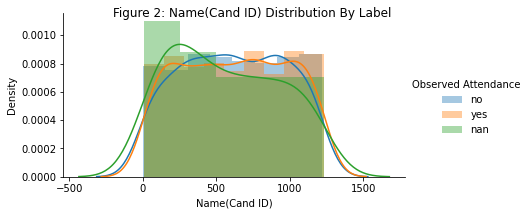

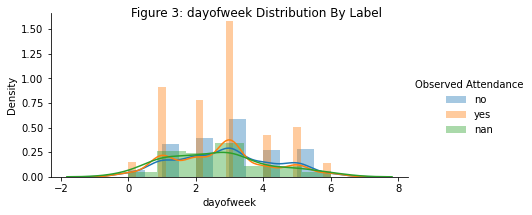

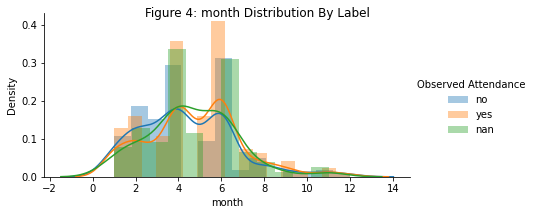

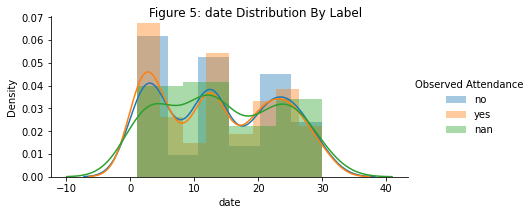

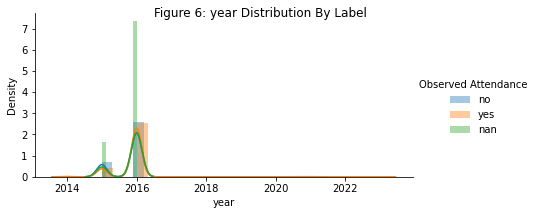

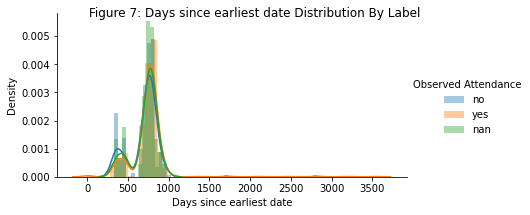

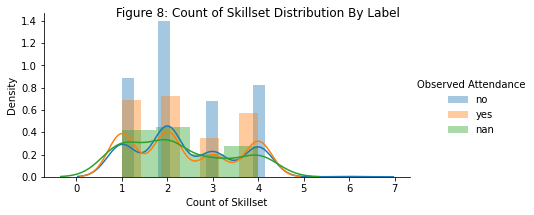

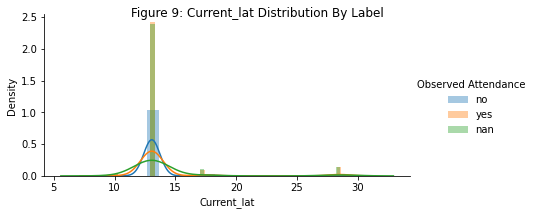

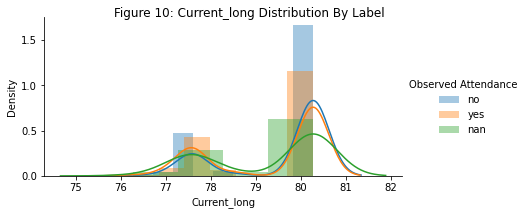

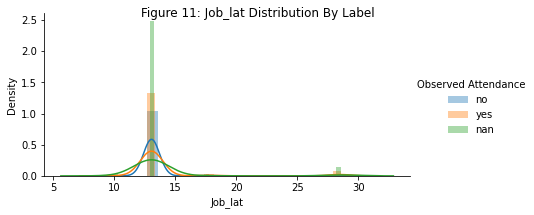

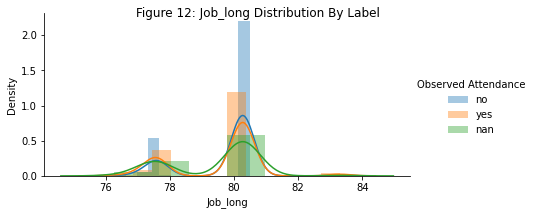

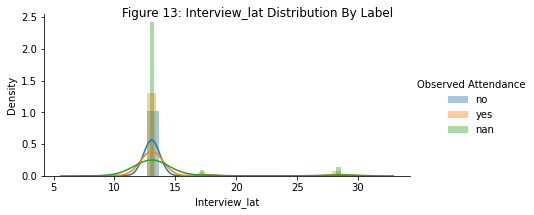

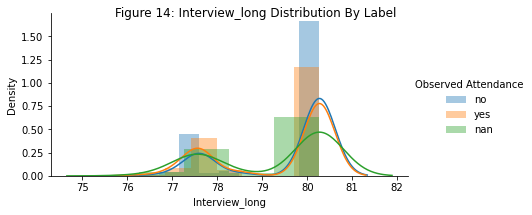

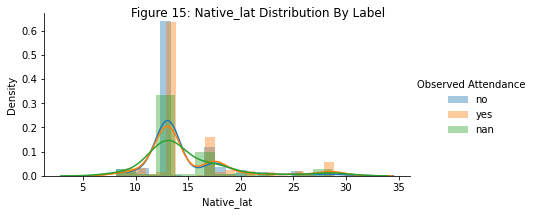

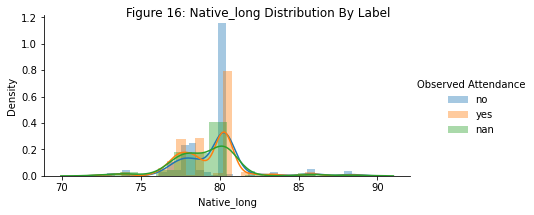

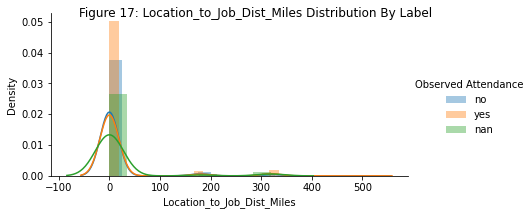

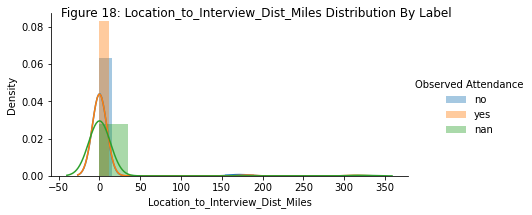

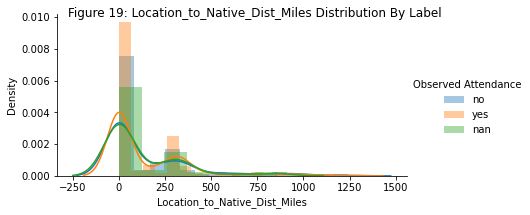

In [45]:
plt.rcParams['figure.max_open_warning']=40
colnames=list(df.select_dtypes(exclude='O').columns.values)
for i in colnames[1:]:
    facet = sns.FacetGrid(df,hue='Observed Attendance',aspect=2)
    facet.map(sns.distplot,i)
    facet.add_legend()
    facet.fig.suptitle(''.join(map(str, list(["Figure ",colnames.index(i)+1,": ",i," Distribution By Label"]))))
    plt.show()

# Visualization of categorical dataset

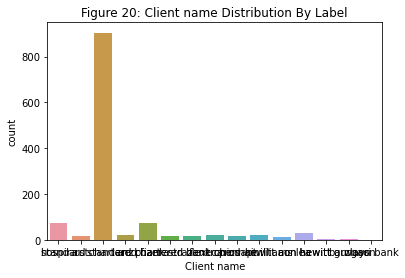

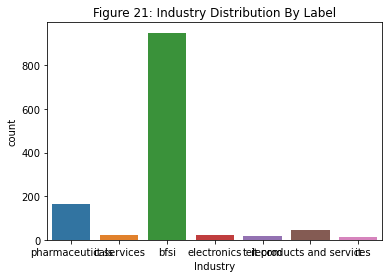

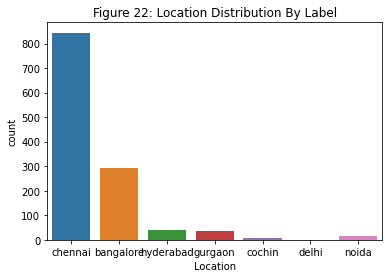

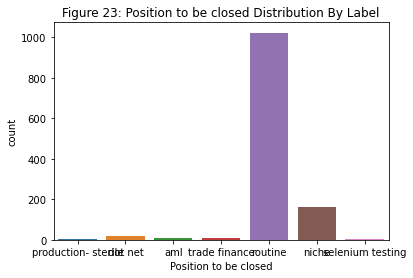

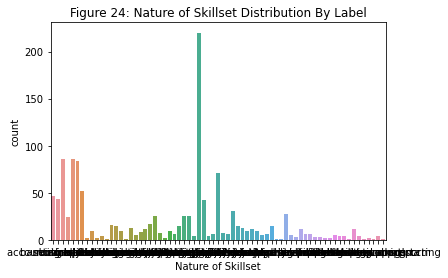

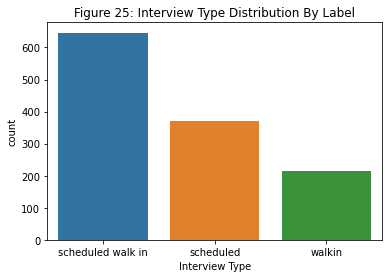

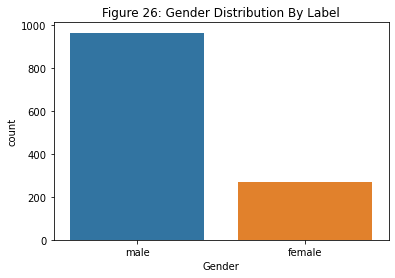

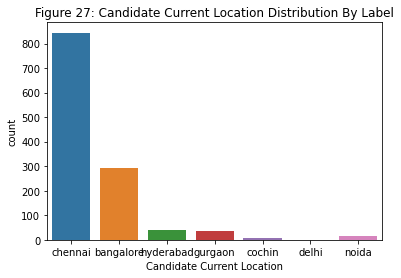

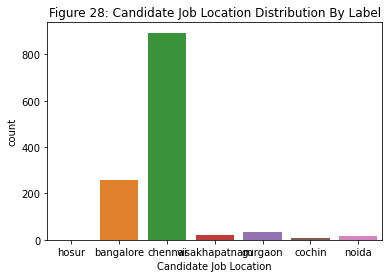

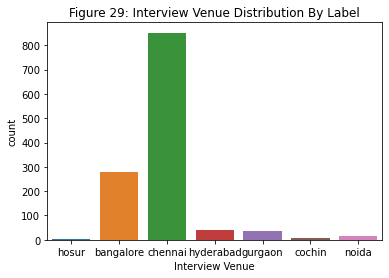

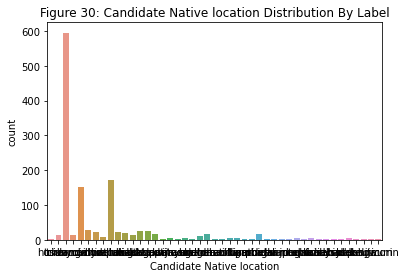

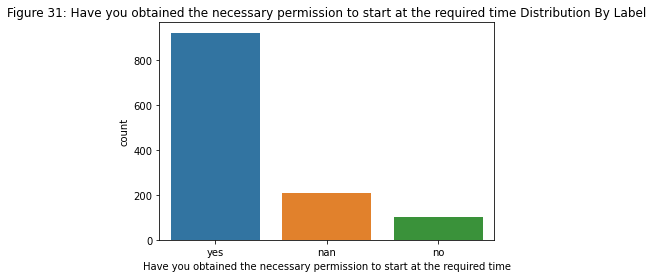

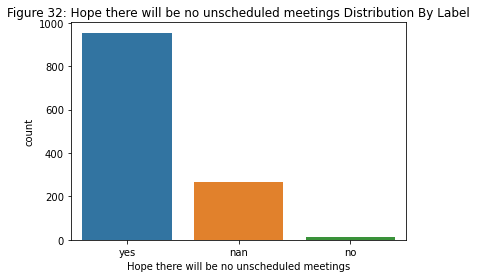

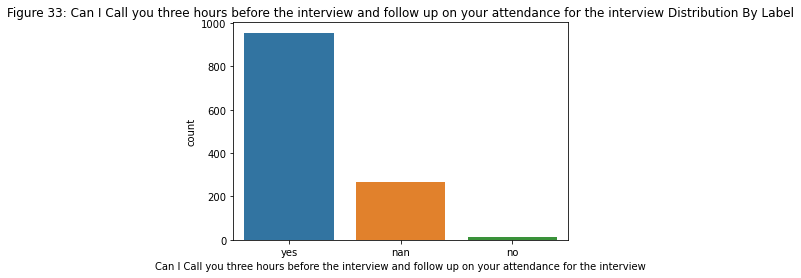

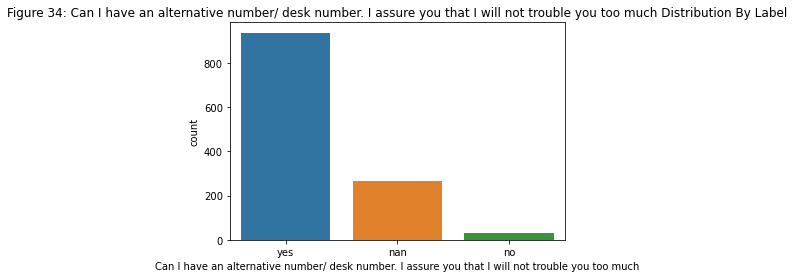

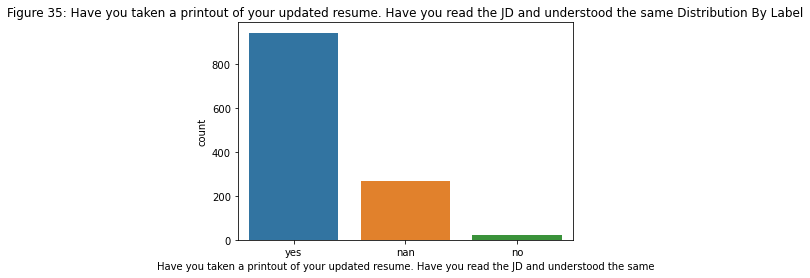

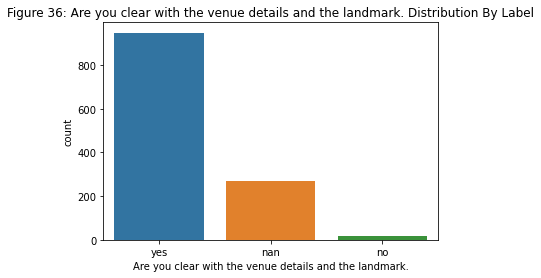

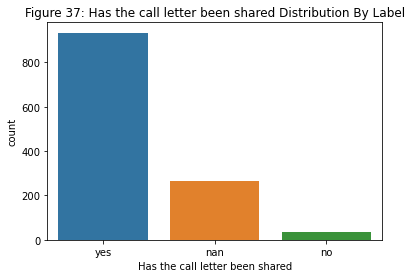

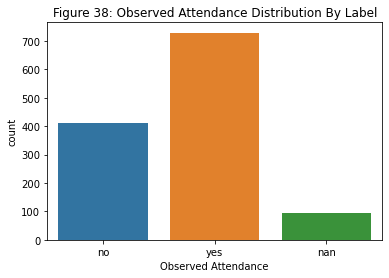

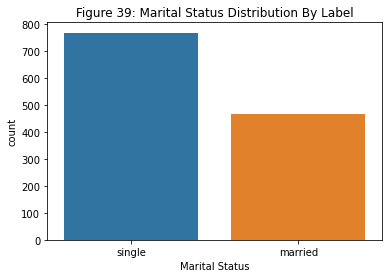

In [46]:
plt.rcParams['figure.max_open_warning']=40
colnames=list(df.select_dtypes(include='O').columns.values)
for i in colnames[0:]:
    ax = plt.axes()
    sns.countplot(x=i, data=df, ax = ax)
    ax.set_title(''.join(map(str, list(["Figure ",colnames.index(i)+20,": ",i," Distribution By Label"]))))
    plt.show()

# Summary of dataset after clean up

In [47]:
df.describe(include = 'O')[:4].T

,count,unique,top,freq
Client name,1233,15,standard chartered bank,904
Industry,1233,7,bfsi,949
Location,1233,7,chennai,844
Position to be closed,1233,7,routine,1023
Nature of Skillset,1233,69,java j2ee struts hibernate,220
Interview Type,1233,3,scheduled walk in,646
Gender,1233,2,male,965
Candidate Current Location,1233,7,chennai,844
Candidate Job Location,1233,7,chennai,893
Interview Venue,1233,7,chennai,852


In [48]:
df.describe()[:4].T

,count,mean,std,min
Name(Cand ID),1233.0,617.000000,356.080749,1.000000
dayofweek,1233.0,2.773723,1.447083,0.000000
month,1233.0,4.616383,2.228350,1.000000
date,1233.0,13.824006,9.176693,1.000000
year,1233.0,2015.847526,0.521716,2014.000000
Days since earliest date,1233.0,720.894566,212.384377,0.000000
Count of Skillset,1233.0,2.350365,1.120443,1.000000
Current_lat,1233.0,13.791338,3.123024,9.931308
Current_long,1233.0,79.422532,1.267891,76.267414
Job_lat,1233.0,13.740940,3.101452,9.931308


# Due to redundancy, remove location and nature of skillset because dummy variables are created for skillset

In [49]:
df = df.drop(columns = ['Location','Nature of Skillset'])

# For the categorical data, create dummy variables and remove the original column

In [50]:
colnames=list(df.select_dtypes(include='O').columns.values)
for i in colnames[0:]:
    # Fill missing data with the word "Missing"
    df[i].fillna("Missing", inplace=True)
    # Create array of dummies
    dummies = pd.get_dummies(df[i], prefix=i)
    # Update X to include dummies and drop the main variable
    df = pd.concat([df, dummies], axis=1)
    df.drop([i], axis=1, inplace=True)

# Drop the binary variables that would be colinear to another column, drop the longitudes and latitudes once distance between cities are solved, and drop datetime variables for a relative date

In [51]:
df = df.drop(columns = ['Date of Interview','Observed Attendance_no','Marital Status_single','Gender_male','Current_lat','Current_long','Job_lat','Job_long','Interview_lat','Interview_long','Native_lat','Native_long'])
df

,Name(Cand ID),dayofweek,month,date,year,Days since earliest date,Count of Skillset,Location_to_Job_Dist_Miles,Location_to_Interview_Dist_Miles,Location_to_Native_Dist_Miles,...,Have you taken a printout of your updated resume. Have you read the JD and understood the same_yes,Are you clear with the venue details and the landmark._nan,Are you clear with the venue details and the landmark._no,Are you clear with the venue details and the landmark._yes,Has the call letter been shared_nan,Has the call letter been shared_no,Has the call letter been shared_yes,Observed Attendance_nan,Observed Attendance_yes,Marital Status_married
0,1,4,2,13,2015,332,1,165.938053,165.938053,165.938053,...,1,0,0,1,0,0,1,0,0,0
1,2,4,2,13,2015,332,1,180.433771,165.938053,190.234720,...,1,0,0,1,0,0,1,0,0,0
2,3,4,2,13,2015,332,1,0.000000,165.938053,0.000000,...,0,1,0,0,1,0,0,0,0,0
3,4,4,2,13,2015,332,1,0.000000,165.938053,0.000000,...,0,0,0,1,0,0,1,0,0,0
4,5,4,2,13,2015,332,1,180.433771,165.938053,0.000000,...,1,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1228,1171,3,6,2,2016,807,4,0.000000,0.000000,318.610407,...,1,0,0,1,0,0,1,1,0,0
1229,1189,5,1,30,2016,683,1,0.000000,0.000000,318.610407,...,1,0,0,1,0,0,1,1,0,0
1230,1207,5,1,30,2016,683,1,0.000000,0.000000,318.610407,...,1,0,0,1,0,0,1,1,0,1
1231,1222,1,7,5,2016,840,1,0.000000,0.000000,0.000000,...,1,0,0,1,0,0,1,1,0,0


# concat the skillset dataframe with the main dataframe

In [52]:
df = pd.concat([df, Skillset],axis=1)
df

,Name(Cand ID),dayofweek,month,date,year,Days since earliest date,Count of Skillset,Location_to_Job_Dist_Miles,Location_to_Interview_Dist_Miles,Location_to_Native_Dist_Miles,...,senior,software,spring,sql,sr,struts,support,t,tech,testing
0,1,4,2,13,2015,332,1,165.938053,165.938053,165.938053,...,0,0,0,0,0,0,0,0,0,0
1,2,4,2,13,2015,332,1,180.433771,165.938053,190.234720,...,0,0,0,0,0,0,0,0,0,0
2,3,4,2,13,2015,332,1,0.000000,165.938053,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,4,4,2,13,2015,332,1,0.000000,165.938053,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,5,4,2,13,2015,332,1,180.433771,165.938053,0.000000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1228,1171,3,6,2,2016,807,4,0.000000,0.000000,318.610407,...,0,0,0,0,0,1,0,0,0,0
1229,1189,5,1,30,2016,683,1,0.000000,0.000000,318.610407,...,0,0,0,0,0,0,0,0,0,0
1230,1207,5,1,30,2016,683,1,0.000000,0.000000,318.610407,...,0,0,0,0,0,0,0,0,0,0
1231,1222,1,7,5,2016,840,1,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0


# Create a checkpoint of the dataset after clean up towards the modeling of the dataset to load up later when predicting Attendance for null values

In [53]:
checkpoint2 = df

# Task 1 - Model Development
### a. Create a model predicting if a candidate will attend an interview. This will be indicated by the "Observed Attendance" column in the data set. Create the model only using the records where this column is not null. Treat your notebook as if a technical product manager will be reading it and trying to understand your work. 


In [54]:
# df = checkpoint2

# Remove the rows that has NaN's for the Observed Attendance column

In [55]:
dataset = df[df['Observed Attendance_nan']!=1].reset_index(drop=True).drop(columns = ['Observed Attendance_nan'])
dataset

,Name(Cand ID),dayofweek,month,date,year,Days since earliest date,Count of Skillset,Location_to_Job_Dist_Miles,Location_to_Interview_Dist_Miles,Location_to_Native_Dist_Miles,...,senior,software,spring,sql,sr,struts,support,t,tech,testing
0,1,4,2,13,2015,332,1,165.938053,165.938053,165.938053,...,0,0,0,0,0,0,0,0,0,0
1,2,4,2,13,2015,332,1,180.433771,165.938053,190.234720,...,0,0,0,0,0,0,0,0,0,0
2,3,4,2,13,2015,332,1,0.000000,165.938053,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,4,4,2,13,2015,332,1,0.000000,165.938053,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,5,4,2,13,2015,332,1,180.433771,165.938053,0.000000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135,1229,1,7,5,2016,840,3,0.000000,0.000000,180.433771,...,0,0,0,0,0,0,0,0,0,0
1136,1230,1,7,5,2016,840,1,0.000000,0.000000,318.610407,...,0,0,0,0,0,0,0,0,0,0
1137,1231,6,6,5,2016,810,1,0.000000,0.000000,318.610407,...,0,0,0,0,0,0,0,0,0,0
1138,1232,6,6,5,2016,810,3,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0


# Separate the target variable from the rest of the dataset

In [56]:
y = dataset.pop('Observed Attendance_yes')

# Use minmaxscalar to scale all the dataset on a 0 to 1 scale for coefficient comparisons later for important features. Use stratified K fold with a set random state to shuffle the sampling set yet keep the results reproducible with the set random state

In [57]:
columns = dataset.columns
sc = MinMaxScaler(feature_range=(0, 1))
dataset = sc.fit_transform(dataset)
dataset = pd.DataFrame(dataset, columns=columns)

#x_train, x_test, y_train, y_test = train_test_split(df, y_int, test_size=0.33, random_state=2, stratify=y_int)
skf = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 2)

# Because the dataset has more attendance than nonattendance, use the balanced function in logistic binary prediction as a baseline for what the results look like based on precision, recall, and F1-score

In [58]:
model2 = LogisticRegression(class_weight='balanced', random_state=2, n_jobs=-1)

for train_idx, test_idx in skf.split(dataset, y):
    model2.fit(dataset.loc[train_idx],y.loc[train_idx])
    print(classification_report(y.loc[test_idx],model2.predict(dataset.loc[test_idx])))

              precision    recall  f1-score   support

           0       0.53      0.58      0.56       137
           1       0.75      0.71      0.73       243

    accuracy                           0.67       380
   macro avg       0.64      0.65      0.64       380
weighted avg       0.67      0.67      0.67       380

              precision    recall  f1-score   support

           0       0.54      0.55      0.55       137
           1       0.74      0.74      0.74       243

    accuracy                           0.67       380
   macro avg       0.64      0.64      0.64       380
weighted avg       0.67      0.67      0.67       380

              precision    recall  f1-score   support

           0       0.56      0.43      0.49       137
           1       0.72      0.81      0.76       243

    accuracy                           0.67       380
   macro avg       0.64      0.62      0.62       380
weighted avg       0.66      0.67      0.66       380



# Randomforest could also be used as an example, but the feature importance are only positive instead of negative and positive for the results, so logistic regression is used. Random forest in this case is also less accurate from the baseline metrics

In [59]:
model3 = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=2, n_jobs=-1)

for train_idx, test_idx in skf.split(dataset, y):
    model3.fit(dataset.loc[train_idx],y.loc[train_idx])
    print(classification_report(y.loc[test_idx],model3.predict(dataset.loc[test_idx])))

              precision    recall  f1-score   support

           0       0.45      0.42      0.43       137
           1       0.68      0.71      0.70       243

    accuracy                           0.61       380
   macro avg       0.57      0.56      0.56       380
weighted avg       0.60      0.61      0.60       380

              precision    recall  f1-score   support

           0       0.53      0.46      0.49       137
           1       0.72      0.77      0.74       243

    accuracy                           0.66       380
   macro avg       0.62      0.61      0.61       380
weighted avg       0.65      0.66      0.65       380

              precision    recall  f1-score   support

           0       0.47      0.41      0.44       137
           1       0.69      0.74      0.71       243

    accuracy                           0.62       380
   macro avg       0.58      0.57      0.58       380
weighted avg       0.61      0.62      0.61       380



# Logistic regression with cross validation is used to provide baseline metrics before hyperparameter optimization

In [60]:
model4 = LogisticRegressionCV(class_weight='balanced', random_state=2, n_jobs=-1)

for train_idx, test_idx in skf.split(dataset, y):
    model4.fit(dataset.loc[train_idx],y.loc[train_idx])
    print(classification_report(y.loc[test_idx],model4.predict(dataset.loc[test_idx])))

              precision    recall  f1-score   support

           0       0.59      0.39      0.47       137
           1       0.71      0.84      0.77       243

    accuracy                           0.68       380
   macro avg       0.65      0.62      0.62       380
weighted avg       0.67      0.68      0.66       380

              precision    recall  f1-score   support

           0       0.66      0.43      0.52       137
           1       0.73      0.88      0.80       243

    accuracy                           0.72       380
   macro avg       0.70      0.65      0.66       380
weighted avg       0.71      0.72      0.70       380

              precision    recall  f1-score   support

           0       0.58      0.37      0.45       137
           1       0.71      0.85      0.77       243

    accuracy                           0.68       380
   macro avg       0.64      0.61      0.61       380
weighted avg       0.66      0.68      0.66       380



# Using gridsearch, find the best solver and penalty for the logistic regression with cross validation model by feeding the best estimator back into the loop

In [61]:
hyperparameters = [{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
              {'penalty':['none', 'elasticnet', 'l1', 'l2']}]

lr = LogisticRegressionCV(class_weight='balanced',n_jobs=-1, random_state=2)

for parameter in hyperparameters:
    search = GridSearchCV(lr, parameter,  
                               scoring = 'accuracy',
                               cv = 5,
                               verbose=3)

    search.fit(dataset.loc[train_idx],y.loc[train_idx])
    lr = search.best_estimator_
    print(search.best_estimator_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ..................solver=newton-cg;, score=0.717 total time=   1.0s
[CV 2/5] END ..................solver=newton-cg;, score=0.717 total time=   0.9s
[CV 3/5] END ..................solver=newton-cg;, score=0.737 total time=   1.2s
[CV 4/5] END ..................solver=newton-cg;, score=0.697 total time=   1.1s
[CV 5/5] END ..................solver=newton-cg;, score=0.678 total time=   1.1s
[CV 1/5] END ......................solver=lbfgs;, score=0.717 total time=   0.5s
[CV 2/5] END ......................solver=lbfgs;, score=0.717 total time=   0.6s
[CV 3/5] END ......................solver=lbfgs;, score=0.737 total time=   0.6s
[CV 4/5] END ......................solver=lbfgs;, score=0.697 total time=   0.6s
[CV 5/5] END ......................solver=lbfgs;, score=0.678 total time=   0.5s
[CV 1/5] END ..................solver=liblinear;, score=0.704 total time=   0.1s
[CV 2/5] END ..................solver=liblinear;,

# For logistic regression with CV, L2 and newton-cg are the best hyperparameters for better accuracy for the metrics provided

In [62]:
model4 = search.best_estimator_

for train_idx, test_idx in skf.split(dataset, y):
    model4.fit(dataset.loc[train_idx],y.loc[train_idx])
    print(classification_report(y.loc[test_idx],model4.predict(dataset.loc[test_idx])))

              precision    recall  f1-score   support

           0       0.59      0.39      0.47       137
           1       0.71      0.84      0.77       243

    accuracy                           0.68       380
   macro avg       0.65      0.62      0.62       380
weighted avg       0.67      0.68      0.66       380

              precision    recall  f1-score   support

           0       0.66      0.43      0.52       137
           1       0.73      0.88      0.80       243

    accuracy                           0.72       380
   macro avg       0.70      0.65      0.66       380
weighted avg       0.71      0.72      0.70       380

              precision    recall  f1-score   support

           0       0.58      0.37      0.45       137
           1       0.71      0.85      0.77       243

    accuracy                           0.68       380
   macro avg       0.64      0.61      0.61       380
weighted avg       0.66      0.68      0.66       380



# for the logistic regression CV model, here are the positive and negative features that would influence a candidate to show up to an interview, further explanations later

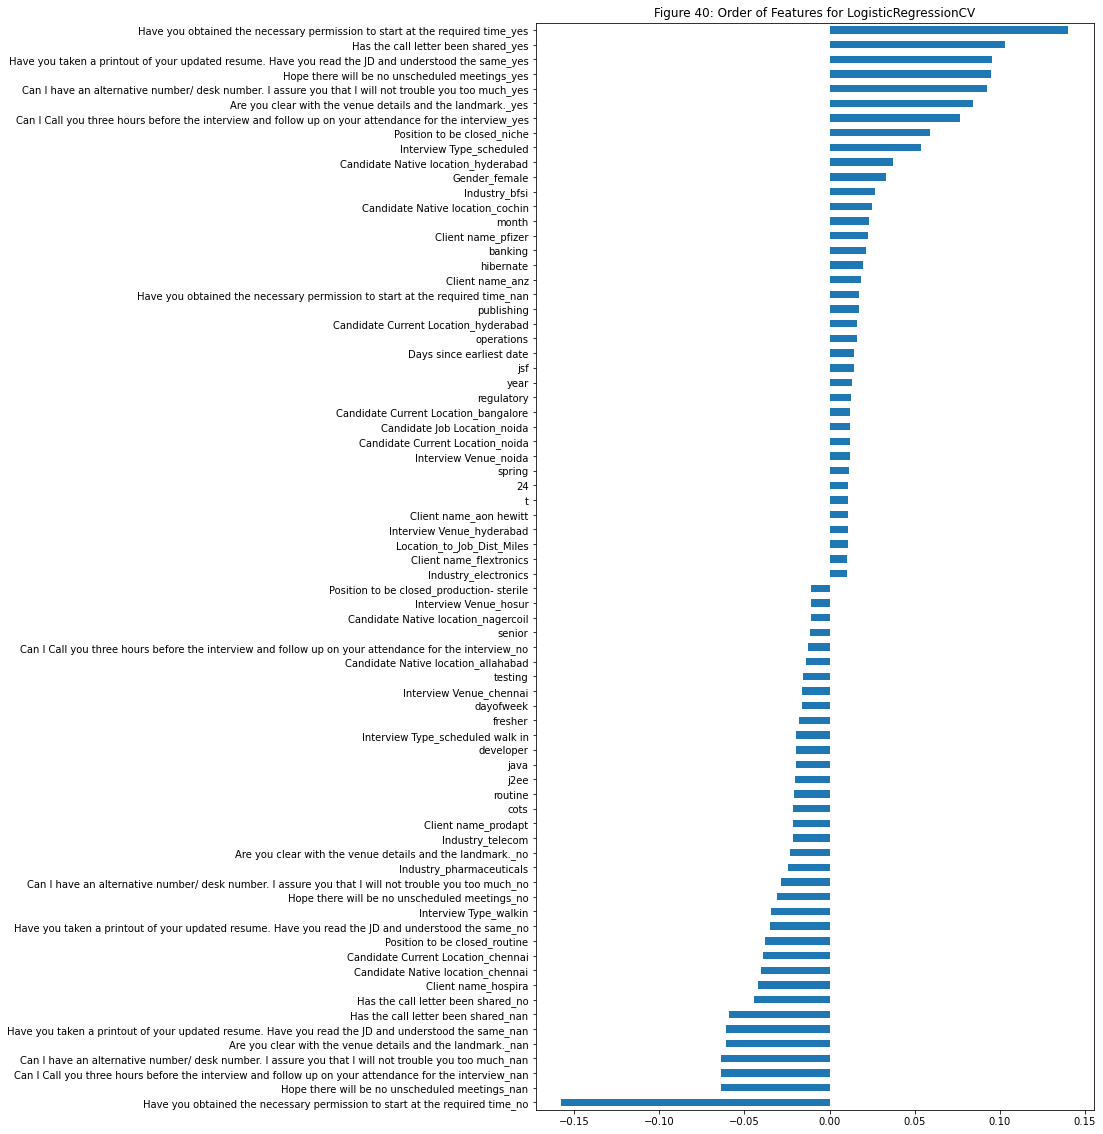

In [63]:
feature_importances = pd.Series(model4.coef_[0], index=dataset.columns)
feature_importances[abs(feature_importances)>0.01].sort_values().plot(kind="barh", figsize=(10,20),
                                       title = "Figure 40: Order of Features for " + str(model4).split("(")[0]);

# save the important features for a later subset of the main dataset for less overfitting of a later model

In [64]:
features1 = pd.DataFrame(feature_importances[abs(feature_importances)>0.01])
features1

,0
dayofweek,-0.016113
month,0.023317
year,0.012969
Days since earliest date,0.014221
Location_to_Job_Dist_Miles,0.010771
...,...
routine,-0.021145
senior,-0.011523
spring,0.011426
t,0.011075


# Logistic regression with the most common parameters is used to provide baseline metrics before hyperparameter optimization

In [65]:
model5 = LogisticRegression(class_weight='balanced',penalty='l1', C=0.5, max_iter=100, solver='liblinear',random_state=2, n_jobs=-1)

for train_idx, test_idx in skf.split(dataset, y):
    model5.fit(dataset.loc[train_idx],y.loc[train_idx])
    print(classification_report(y.loc[test_idx],model5.predict(dataset.loc[test_idx])))

              precision    recall  f1-score   support

           0       0.54      0.55      0.55       137
           1       0.75      0.74      0.74       243

    accuracy                           0.67       380
   macro avg       0.64      0.65      0.64       380
weighted avg       0.67      0.67      0.67       380

              precision    recall  f1-score   support

           0       0.52      0.50      0.51       137
           1       0.72      0.74      0.73       243

    accuracy                           0.66       380
   macro avg       0.62      0.62      0.62       380
weighted avg       0.65      0.66      0.65       380

              precision    recall  f1-score   support

           0       0.58      0.45      0.51       137
           1       0.73      0.81      0.77       243

    accuracy                           0.68       380
   macro avg       0.65      0.63      0.64       380
weighted avg       0.67      0.68      0.67       380



# Using gridsearch, find the best solver and penalty for the logistic regression model by feeding the best estimator back into the loop

In [66]:
hyperparameters = [{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
                   {'C':[0.001, 0.01, 0.1, 1, 10, 100]},
              {'penalty':['none', 'elasticnet', 'l1', 'l2']}]

lr = LogisticRegression(class_weight='balanced',n_jobs=-1, random_state=2)

for parameter in hyperparameters:
    search = GridSearchCV(lr, parameter,  
                               scoring = 'accuracy',
                               cv = 5,
                               verbose=3)

    search.fit(dataset.loc[train_idx],y.loc[train_idx])
    lr = search.best_estimator_
    print(search.best_estimator_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ..................solver=newton-cg;, score=0.711 total time=   0.0s
[CV 2/5] END ..................solver=newton-cg;, score=0.618 total time=   0.0s
[CV 3/5] END ..................solver=newton-cg;, score=0.592 total time=   0.0s
[CV 4/5] END ..................solver=newton-cg;, score=0.572 total time=   0.0s
[CV 5/5] END ..................solver=newton-cg;, score=0.684 total time=   0.0s
[CV 1/5] END ......................solver=lbfgs;, score=0.711 total time=   0.0s
[CV 2/5] END ......................solver=lbfgs;, score=0.618 total time=   0.0s
[CV 3/5] END ......................solver=lbfgs;, score=0.592 total time=   0.0s
[CV 4/5] END ......................solver=lbfgs;, score=0.572 total time=   0.0s
[CV 5/5] END ......................solver=lbfgs;, score=0.684 total time=   0.0s
[CV 1/5] END ..................solver=liblinear;, score=0.711 total time=   0.0s
[CV 2/5] END ..................solver=liblinear;,

# For logistic regression, C=0.01, L2, and liblinear are the best hyperparameters for better accuracy for the metrics provided

In [67]:
model5 = search.best_estimator_

for train_idx, test_idx in skf.split(dataset, y):
    model5.fit(dataset.loc[train_idx],y.loc[train_idx])
    print(classification_report(y.loc[test_idx],model5.predict(dataset.loc[test_idx])))

              precision    recall  f1-score   support

           0       0.61      0.49      0.54       137
           1       0.74      0.82      0.78       243

    accuracy                           0.70       380
   macro avg       0.67      0.66      0.66       380
weighted avg       0.69      0.70      0.69       380

              precision    recall  f1-score   support

           0       0.61      0.50      0.55       137
           1       0.74      0.82      0.78       243

    accuracy                           0.71       380
   macro avg       0.68      0.66      0.66       380
weighted avg       0.70      0.71      0.70       380

              precision    recall  f1-score   support

           0       0.57      0.36      0.44       137
           1       0.70      0.84      0.77       243

    accuracy                           0.67       380
   macro avg       0.64      0.60      0.61       380
weighted avg       0.65      0.67      0.65       380



# for the logistic regression model, here are the positive and negative features that would influence a candidate to show up to an interview, further explanations later

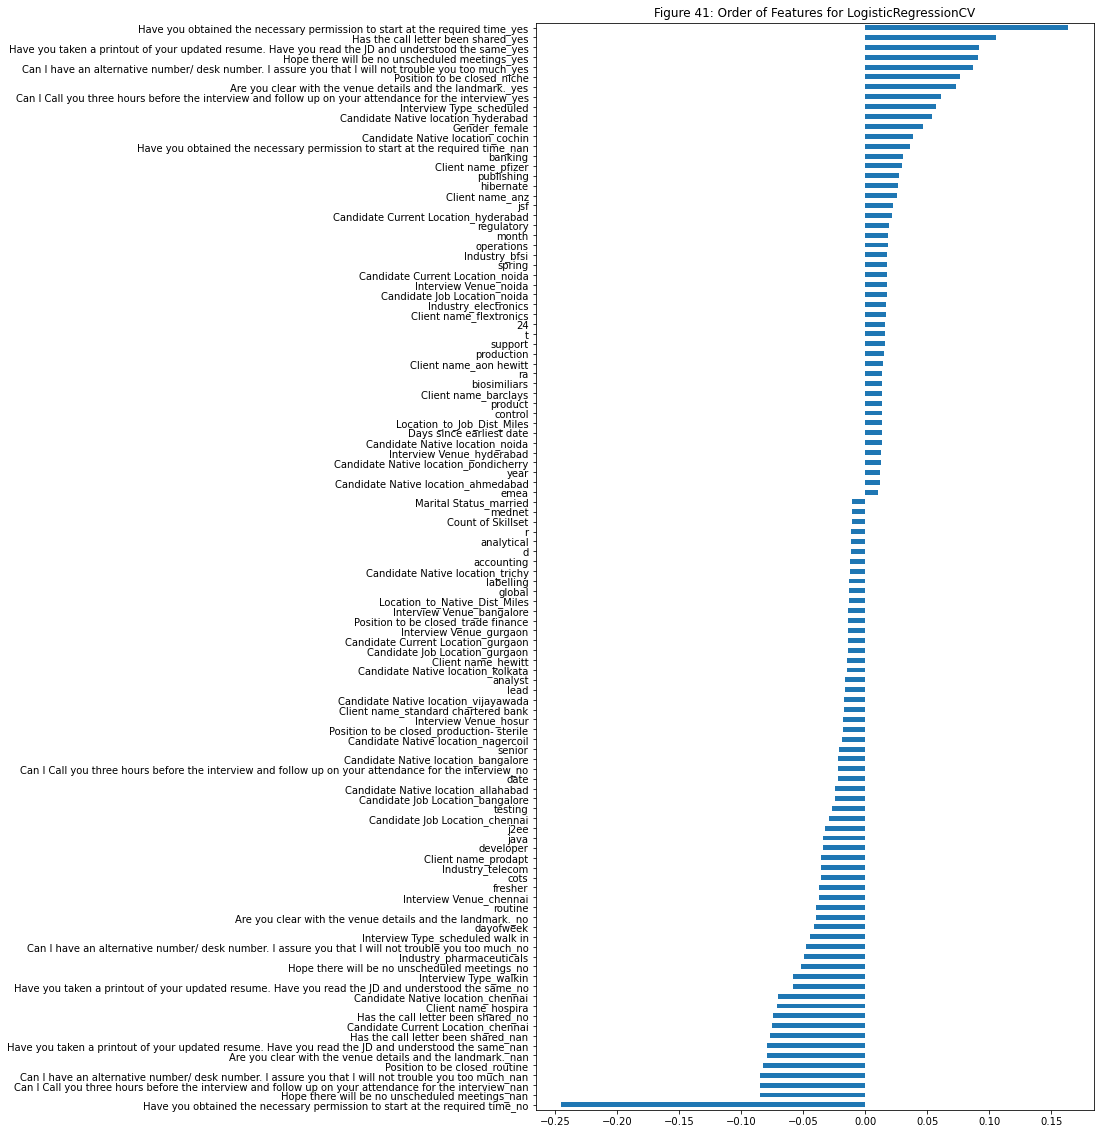

In [68]:
feature_importances = pd.Series(model5.coef_[0], index=dataset.columns)
feature_importances[abs(feature_importances)>0.01].sort_values().plot(kind="barh", figsize=(10,20),
                                       title = "Figure 41: Order of Features for " + str(model4).split("(")[0]);

# save the important features for a later subset of the main dataset for less overfitting of a later model

In [69]:
features2 = pd.DataFrame(feature_importances[abs(feature_importances)>0.01])
features2

,0
dayofweek,-0.041428
month,0.018515
date,-0.022098
year,0.011767
Days since earliest date,0.013491
...,...
senior,-0.021201
spring,0.017529
support,0.015665
t,0.016356


# Given that logistic regression and logistic regression with CV are similar with the same model, the important features are combined to form a subset of the main dataset for further iterative fitting

In [70]:
keep = pd.DataFrame(pd.concat([features1,features2],axis=1).fillna(0).T.mean()).sort_values(0)
keep

,0
Have you obtained the necessary permission to start at the required time_no,-0.201503
Can I have an alternative number/ desk number. I assure you that I will not trouble you too much_nan,-0.074429
Hope there will be no unscheduled meetings_nan,-0.074429
Can I Call you three hours before the interview and follow up on your attendance for the interview_nan,-0.074429
Are you clear with the venue details and the landmark._nan,-0.070167
...,...
Can I have an alternative number/ desk number. I assure you that I will not trouble you too much_yes,0.089728
Hope there will be no unscheduled meetings_yes,0.092643
Have you taken a printout of your updated resume. Have you read the JD and understood the same_yes,0.093737
Has the call letter been shared_yes,0.104489


# from 188 columns, the dataset is reduced to 111 columns after removing nonessential features

In [71]:
dataset = dataset[keep.index]
dataset

,Have you obtained the necessary permission to start at the required time_no,Can I have an alternative number/ desk number. I assure you that I will not trouble you too much_nan,Hope there will be no unscheduled meetings_nan,Can I Call you three hours before the interview and follow up on your attendance for the interview_nan,Are you clear with the venue details and the landmark._nan,Have you taken a printout of your updated resume. Have you read the JD and understood the same_nan,Has the call letter been shared_nan,Position to be closed_routine,Has the call letter been shared_no,Candidate Current Location_chennai,...,Candidate Native location_hyderabad,Interview Type_scheduled,Position to be closed_niche,Can I Call you three hours before the interview and follow up on your attendance for the interview_yes,Are you clear with the venue details and the landmark._yes,Can I have an alternative number/ desk number. I assure you that I will not trouble you too much_yes,Hope there will be no unscheduled meetings_yes,Have you taken a printout of your updated resume. Have you read the JD and understood the same_yes,Has the call letter been shared_yes,Have you obtained the necessary permission to start at the required time_yes
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1136,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1137,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


# Fit the truncated dataset with hyperparameter optimization using gridsearch by feeding the best estimator back into the logistic regression with CV model

In [72]:
hyperparameters = [{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
              {'penalty':['none', 'elasticnet', 'l1', 'l2']}]

lr = LogisticRegressionCV(class_weight='balanced',n_jobs=-1, random_state=2)

for parameter in hyperparameters:
    search = GridSearchCV(lr, parameter,  
                               scoring = 'accuracy',
                               cv = 5,
                               verbose=3)

    search.fit(dataset.loc[train_idx],y.loc[train_idx])
    lr = search.best_estimator_
    print(search.best_estimator_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ..................solver=newton-cg;, score=0.724 total time=   0.6s
[CV 2/5] END ..................solver=newton-cg;, score=0.711 total time=   0.6s
[CV 3/5] END ..................solver=newton-cg;, score=0.737 total time=   0.8s
[CV 4/5] END ..................solver=newton-cg;, score=0.697 total time=   0.8s
[CV 5/5] END ..................solver=newton-cg;, score=0.691 total time=   0.6s
[CV 1/5] END ......................solver=lbfgs;, score=0.724 total time=   0.5s
[CV 2/5] END ......................solver=lbfgs;, score=0.711 total time=   0.5s
[CV 3/5] END ......................solver=lbfgs;, score=0.737 total time=   0.6s
[CV 4/5] END ......................solver=lbfgs;, score=0.697 total time=   0.6s
[CV 5/5] END ......................solver=lbfgs;, score=0.691 total time=   0.5s
[CV 1/5] END ..................solver=liblinear;, score=0.724 total time=   0.1s
[CV 2/5] END ..................solver=liblinear;,

# in this case, logistic regression with CV has the same hyperparameters as last time for higher metrics in precision, recall, and f1-score

In [73]:
model6 = search.best_estimator_

for train_idx, test_idx in skf.split(dataset, y):
    model6.fit(dataset.loc[train_idx],y.loc[train_idx])
    print(classification_report(y.loc[test_idx],model6.predict(dataset.loc[test_idx])))

              precision    recall  f1-score   support

           0       0.59      0.39      0.47       137
           1       0.71      0.84      0.77       243

    accuracy                           0.68       380
   macro avg       0.65      0.62      0.62       380
weighted avg       0.67      0.68      0.66       380

              precision    recall  f1-score   support

           0       0.66      0.42      0.52       137
           1       0.73      0.88      0.80       243

    accuracy                           0.71       380
   macro avg       0.69      0.65      0.66       380
weighted avg       0.70      0.71      0.70       380

              precision    recall  f1-score   support

           0       0.57      0.36      0.45       137
           1       0.70      0.85      0.77       243

    accuracy                           0.67       380
   macro avg       0.64      0.61      0.61       380
weighted avg       0.66      0.67      0.65       380



# feature importance of the new logistic regression with CV model is ordered for the target variable for attending, more explanations later

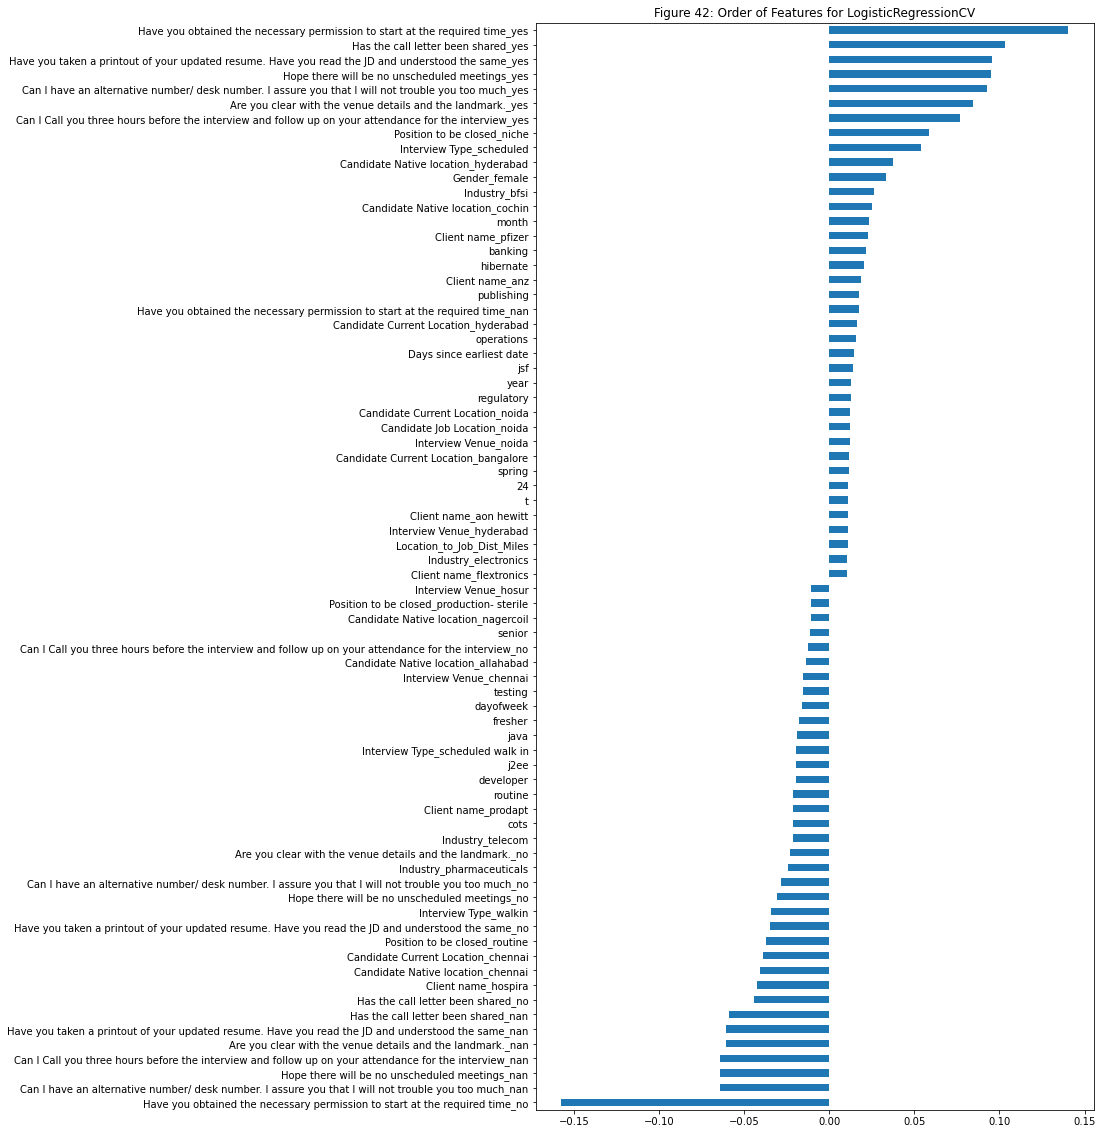

In [74]:
feature_importances = pd.Series(model6.coef_[0], index=dataset.columns)
feature_importances[abs(feature_importances)>0.01].sort_values().plot(kind="barh", figsize=(10,20),
                                       title = "Figure 42: Order of Features for " + str(model6).split("(")[0]);

# For the features importance, only keep the features that is absolute value 0.01 or more

In [75]:
features3 = pd.DataFrame(feature_importances[abs(feature_importances)>0.01])
features3

,0
Have you obtained the necessary permission to start at the required time_no,-0.157748
Can I have an alternative number/ desk number. I assure you that I will not trouble you too much_nan,-0.064122
Hope there will be no unscheduled meetings_nan,-0.064122
Can I Call you three hours before the interview and follow up on your attendance for the interview_nan,-0.064122
Are you clear with the venue details and the landmark._nan,-0.061014
...,...
Can I have an alternative number/ desk number. I assure you that I will not trouble you too much_yes,0.092641
Hope there will be no unscheduled meetings_yes,0.094844
Have you taken a printout of your updated resume. Have you read the JD and understood the same_yes,0.095640
Has the call letter been shared_yes,0.103315


# Fit the truncated dataset with hyperparameter optimization using gridsearch by feeding the best estimator back into the logistic regression model

In [76]:
hyperparameters = [{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
                   {'C':[0.001, 0.01, 0.1, 1, 10, 100]},
              {'penalty':['none', 'elasticnet', 'l1', 'l2']}]

lr = LogisticRegression(class_weight='balanced',n_jobs=-1, random_state=2)

for parameter in hyperparameters:
    search = GridSearchCV(lr, parameter,  
                               scoring = 'accuracy',
                               cv = 5,
                               verbose=3)

    search.fit(dataset.loc[train_idx],y.loc[train_idx])
    lr = search.best_estimator_
    print(search.best_estimator_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ..................solver=newton-cg;, score=0.724 total time=   0.0s
[CV 2/5] END ..................solver=newton-cg;, score=0.697 total time=   0.0s
[CV 3/5] END ..................solver=newton-cg;, score=0.612 total time=   0.0s
[CV 4/5] END ..................solver=newton-cg;, score=0.579 total time=   0.0s
[CV 5/5] END ..................solver=newton-cg;, score=0.697 total time=   0.0s
[CV 1/5] END ......................solver=lbfgs;, score=0.724 total time=   0.0s
[CV 2/5] END ......................solver=lbfgs;, score=0.697 total time=   0.0s
[CV 3/5] END ......................solver=lbfgs;, score=0.612 total time=   0.0s
[CV 4/5] END ......................solver=lbfgs;, score=0.579 total time=   0.0s
[CV 5/5] END ......................solver=lbfgs;, score=0.697 total time=   0.0s
[CV 1/5] END ..................solver=liblinear;, score=0.724 total time=   0.0s
[CV 2/5] END ..................solver=liblinear;,

# in this case, logistic regression has the same hyperparameters as last time for higher metrics in precision, recall, and f1-score

In [77]:
model7 = search.best_estimator_

for train_idx, test_idx in skf.split(dataset, y):
    model7.fit(dataset.loc[train_idx],y.loc[train_idx])
    print(classification_report(y.loc[test_idx],model7.predict(dataset.loc[test_idx])))

              precision    recall  f1-score   support

           0       0.62      0.51      0.56       137
           1       0.75      0.82      0.78       243

    accuracy                           0.71       380
   macro avg       0.68      0.67      0.67       380
weighted avg       0.70      0.71      0.70       380

              precision    recall  f1-score   support

           0       0.62      0.50      0.55       137
           1       0.74      0.83      0.78       243

    accuracy                           0.71       380
   macro avg       0.68      0.66      0.67       380
weighted avg       0.70      0.71      0.70       380

              precision    recall  f1-score   support

           0       0.57      0.38      0.46       137
           1       0.71      0.84      0.77       243

    accuracy                           0.67       380
   macro avg       0.64      0.61      0.61       380
weighted avg       0.66      0.67      0.65       380



# feature importance of the new logistic regression with CV model is ordered for the target variable for attending, more explanations later

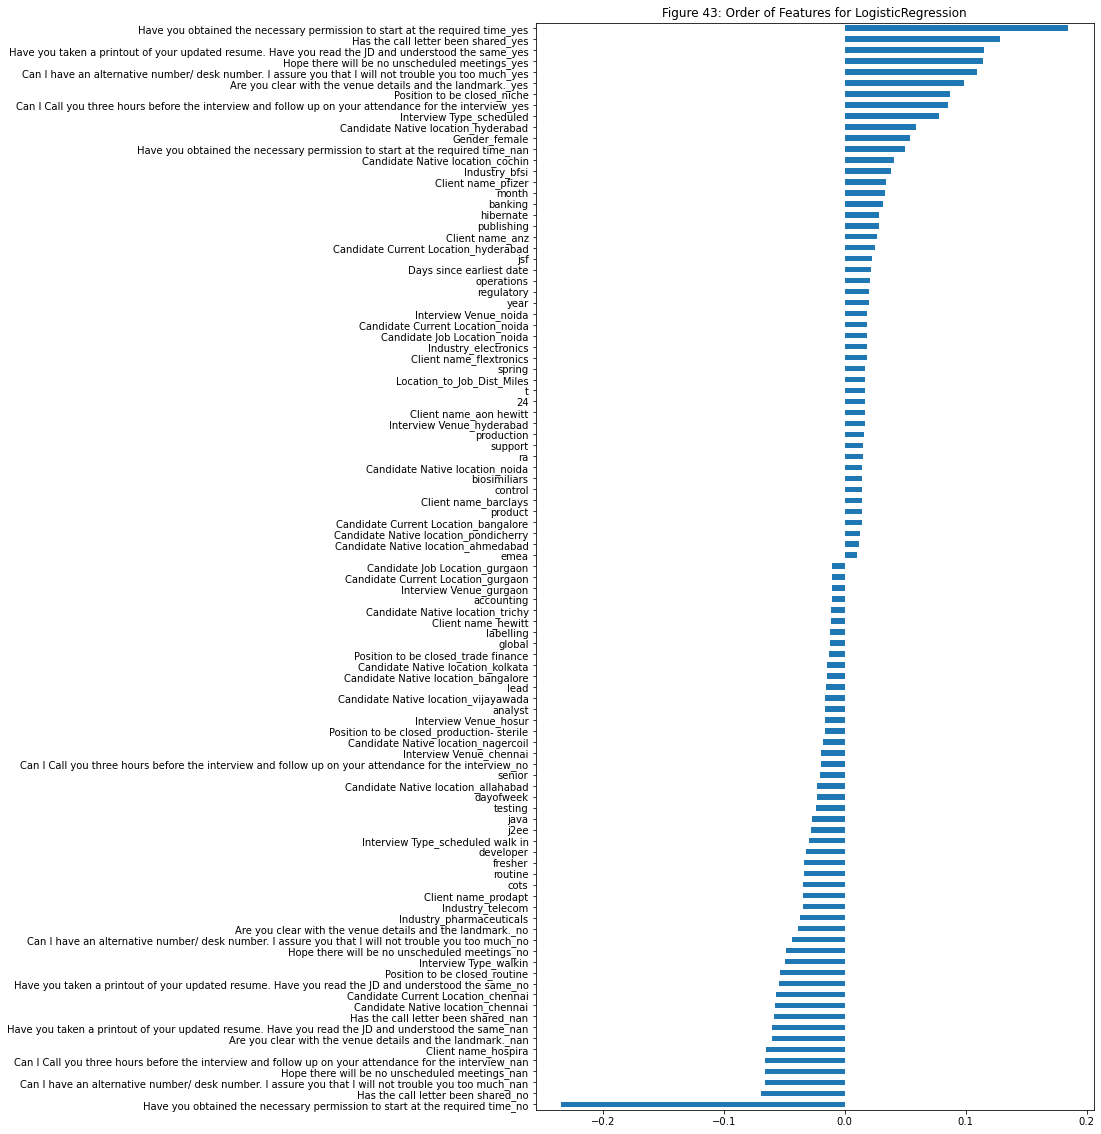

In [78]:
feature_importances = pd.Series(model7.coef_[0], index=dataset.columns)
feature_importances[abs(feature_importances)>0.01].sort_values().plot(kind="barh", figsize=(10,20),
                                       title = "Figure 43: Order of Features for " + str(model7).split("(")[0]);

# For the features importance, only keep the features that is absolute value 0.01 or more

In [79]:
features4 = pd.DataFrame(feature_importances[abs(feature_importances)>0.01])
features4

,0
Have you obtained the necessary permission to start at the required time_no,-0.234597
Can I have an alternative number/ desk number. I assure you that I will not trouble you too much_nan,-0.066045
Hope there will be no unscheduled meetings_nan,-0.066045
Can I Call you three hours before the interview and follow up on your attendance for the interview_nan,-0.066045
Are you clear with the venue details and the landmark._nan,-0.060510
...,...
Can I have an alternative number/ desk number. I assure you that I will not trouble you too much_yes,0.109380
Hope there will be no unscheduled meetings_yes,0.114410
Have you taken a printout of your updated resume. Have you read the JD and understood the same_yes,0.115055
Has the call letter been shared_yes,0.128045


# given that the two models both use logistic regression, take the average of the important features and filter out the non essential features

In [80]:
pd.concat([features3,features4],axis=1)

,0,0
Have you obtained the necessary permission to start at the required time_no,-0.157748,-0.234597
Can I have an alternative number/ desk number. I assure you that I will not trouble you too much_nan,-0.064122,-0.066045
Hope there will be no unscheduled meetings_nan,-0.064122,-0.066045
Can I Call you three hours before the interview and follow up on your attendance for the interview_nan,-0.064122,-0.066045
Are you clear with the venue details and the landmark._nan,-0.061014,-0.060510
...,...,...
control,NaN,0.013902
biosimiliars,NaN,0.014289
ra,NaN,0.014787
production,NaN,0.015601


# The total number of important features is reduced to 77 from 77. Given the iterative nature of reducing the important features, another cycle could be done to reduce more features, but for the simplicity of the exercise, only two cycles of this process is done

In [81]:
tot_Features = pd.DataFrame(pd.concat([features3,features4],axis=1).fillna(0).T.mean()).sort_values(0)
tot_Features = tot_Features[abs(tot_Features[0])>.01]
print(tot_Features.to_string())

                                                                                                               0
Have you obtained the necessary permission to start at the required time_no                            -0.196172
Can I have an alternative number/ desk number. I assure you that I will not trouble you too much_nan   -0.065084
Hope there will be no unscheduled meetings_nan                                                         -0.065084
Can I Call you three hours before the interview and follow up on your attendance for the interview_nan -0.065084
Are you clear with the venue details and the landmark._nan                                             -0.060762
Have you taken a printout of your updated resume. Have you read the JD and understood the same_nan     -0.060762
Has the call letter been shared_nan                                                                    -0.058800
Has the call letter been shared_no                                                              

# This is the final visualization of the important features that influnce job interview attendance positively or negatively

### For the features to be more interpretable, logistic regression is used to have both positive and negative features: conclusions:

### 1) For the candidate questionaires regardng permission to start at required time, call letter been shared, print out of resume, no unscheduled meetings, alternative number, venue details, call 3 hours before interview, if the candidate answered yes to all of them, they are more likely to show up for the interview. Alternatively, if the candidate said no to those questions or even worse left those questions blank, they are less likely to show up for the interview

### 2) If the position is to be closed niche, interview is scheduled, industry is bfsi or electronics, client name is pfizer, anz, flextronics, or aon hewitt, if it is later during the year, the location of the job is far from the candidate, the candidate is more likely to show up for interview. If the position is to be closed sterile or routine, more closer to the beginning of the week, is a walk in, industry is telecom or pharmaceuticals, client name is hospira or prodapt, the candidate is less likely to show up for the interview

### 3) There are some data that would be improper to judge the candidate if they would show up for an interview such as their current location, native location, and gender because it may induce classism or gender bias even though it is in the data and prediction model. However, if the interview venue is in noida or hyderabad, candidates are more likely to show up. If the interview is in hosur or chennai, candidates are less likely to show up.

### 4) Based on skillset keywords, if the job entails cots, routine, fresher, developer, j2ee, java, testing, and senior, the candidate is less likely to show up. If the job entails t-24, spring, regulatory, jsf, operations, publishing, hibernate, and banking, the candidate is more likely to show up.

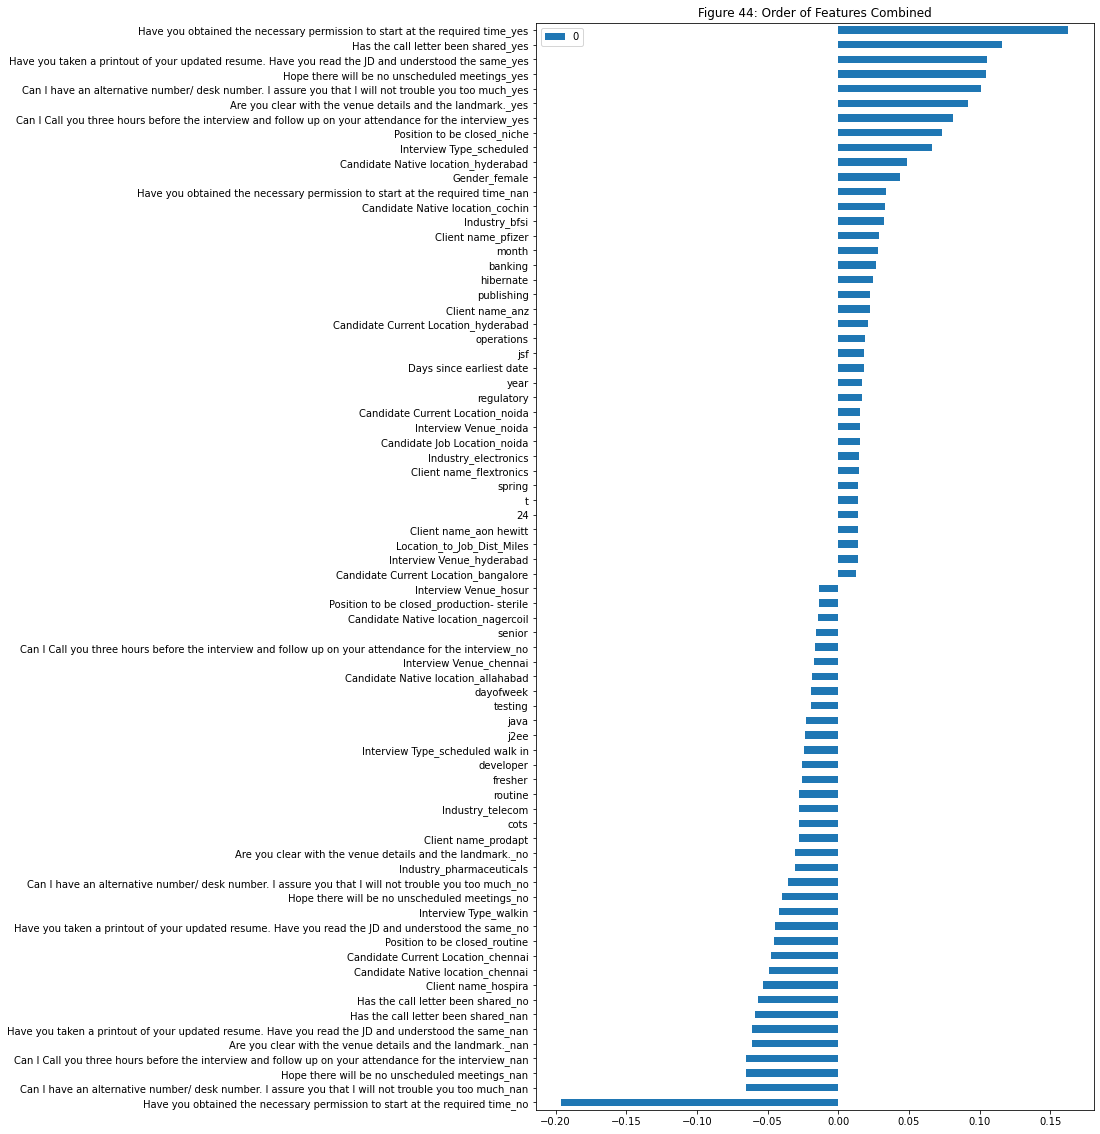

In [82]:
tot_Features.plot(kind="barh", figsize=(10,20),
                                       title = "Figure 44: Order of Features Combined");

# c. Pick one or more accuracy metrics for training and testing sets.

In [83]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Using a confusion matrix, here is the normalized and non-normalized labeling of the logistic regression with and without CV prediction lavel compared to the actual label. Type 1 error is a false positive depicted in the upper right of the square while type 2 error is a false negative depicted in the bottom left of the square. Given that management is more concerned about no-shows to interviews, they should be more concerned about false positives because it is better to have more candidates in the interview pipeline rather than to overestimate people showing up for interviews and yet not have enough candidates interviewing.

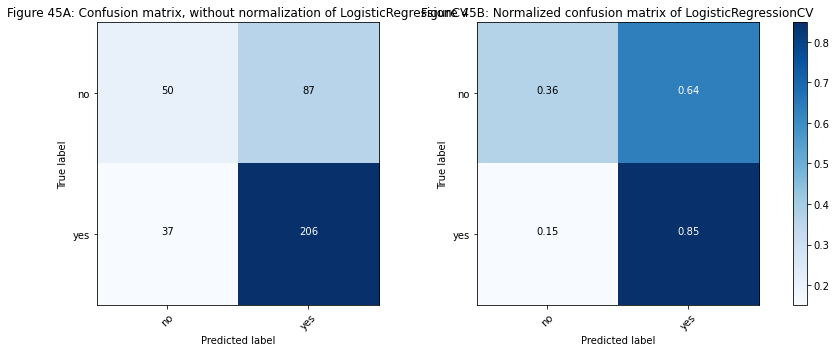

In [84]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y.loc[test_idx],model6.predict(dataset.loc[test_idx]))
np.set_printoptions(precision=2)

class_names = ['no', 'yes']

# Plot non-normalized confusion matrix
plt.figure(figsize = (15,5))
plt.subplot(1, 2, 1)
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Figure 45A: Confusion matrix, without normalization of ' + str(model6).split("(")[0])

# Plot normalized confusion matrix
plt.subplot(1, 2, 2)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Figure 45B: Normalized confusion matrix of ' + str(model6).split("(")[0])

plt.tight_layout()
plt.show()

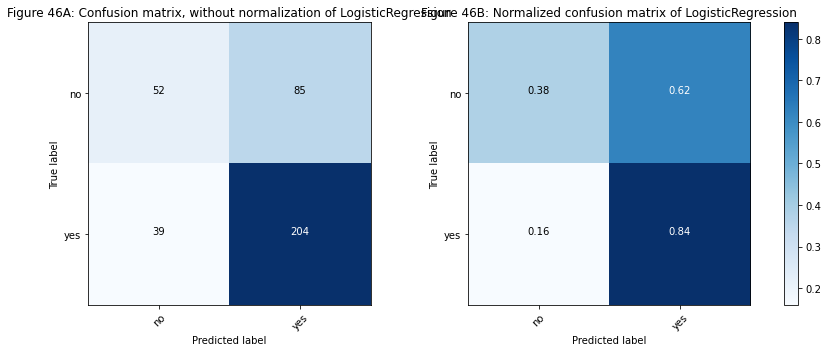

In [85]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y.loc[test_idx],model7.predict(dataset.loc[test_idx]))
np.set_printoptions(precision=2)

class_names = ['no', 'yes']

# Plot non-normalized confusion matrix
plt.figure(figsize = (15,5))
plt.subplot(1, 2, 1)
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Figure 46A: Confusion matrix, without normalization of ' + str(model7).split("(")[0])

# Plot normalized confusion matrix
plt.subplot(1, 2, 2)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Figure 46B: Normalized confusion matrix of ' + str(model7).split("(")[0])

plt.tight_layout()
plt.show()

# Using train test split, calculate the metrics of Roc area under the curve, accuracy, precision, recall, and F1 score for the 80-20 split of the dataset for both logistic regression with and without cross validation models

In [86]:
x_train, x_test, y_train, y_test = train_test_split(dataset, y, test_size=0.2, random_state=2)

In [87]:
def get_metrics(y_true, y_pred, treshhold=.5):
    y_pred = (y_pred > treshhold).astype(np.int32)
    return dict(
        RocAuc="{:.4f}".format(metrics.roc_auc_score(y_test, y_pred)),
        Accuracy="{:.4f}".format(metrics.accuracy_score(y_test, y_pred)),
        Precision="{:.4f}".format(metrics.precision_score(y_test, y_pred)),
        Recall="{:.4f}".format(metrics.recall_score(y_test, y_pred)),
        F1="{:.4f}".format(metrics.f1_score(y_test, y_pred))
    )

# The metrics for both models are about the same with the same shape underneath the curve at 71% accuracy

In [88]:
print("Test Dataset :", get_metrics(y_test, model6.predict(x_test)))

Test Dataset : {'RocAuc': '0.6287', 'Accuracy': '0.7105', 'Precision': '0.7348', 'Recall': '0.8808', 'F1': '0.8012'}


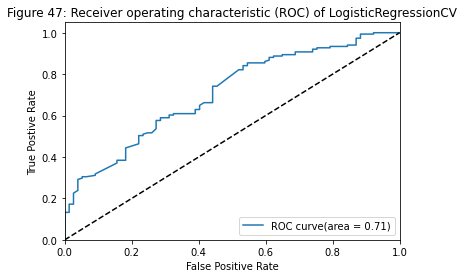

In [89]:
fpr, tpr, thresholds = roc_curve(y_test, model6.predict_proba(x_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='ROC curve(area = %0.2f)' %roc_auc_score(y_test, model6.predict_proba(x_test)[:,1]))
plt.plot([0,1], [0,1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Postive Rate')
plt.title('Figure 47: Receiver operating characteristic (ROC) of ' + str(model6).split("(")[0])
plt.legend(loc='lower right')
plt.show()

In [90]:
print("Test Dataset :", get_metrics(y_test, model7.predict(x_test)))

Test Dataset : {'RocAuc': '0.6319', 'Accuracy': '0.7105', 'Precision': '0.7374', 'Recall': '0.8742', 'F1': '0.8000'}


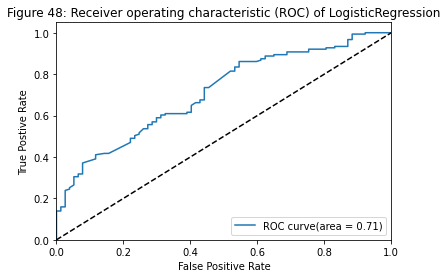

In [91]:
fpr, tpr, thresholds = roc_curve(y_test, model7.predict_proba(x_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='ROC curve(area = %0.2f)' %roc_auc_score(y_test, model7.predict_proba(x_test)[:,1]))
plt.plot([0,1], [0,1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Postive Rate')
plt.title('Figure 48: Receiver operating characteristic (ROC) of ' + str(model7).split("(")[0])
plt.legend(loc='lower right')
plt.show()

# b. Provide a probability and a prediction output for the candidates where the "Observed Attendance" column is null. 

In [92]:
df = checkpoint2
prediction = pd.DataFrame()

# Using the previous checkpoint, retrieve only the dataset where the observed attendance is NaN and predict the attendance for those candidates. Given that the more accurate model requires the dataset with priority on important features, only that subset of the dataset is used

In [93]:
dataset = df[df['Observed Attendance_nan']==1].reset_index(drop=True).drop(columns = ['Observed Attendance_nan'])
prediction['Name(Cand ID)'] = dataset['Name(Cand ID)']
dataset = dataset[keep.index]
dataset

,Have you obtained the necessary permission to start at the required time_no,Can I have an alternative number/ desk number. I assure you that I will not trouble you too much_nan,Hope there will be no unscheduled meetings_nan,Can I Call you three hours before the interview and follow up on your attendance for the interview_nan,Are you clear with the venue details and the landmark._nan,Have you taken a printout of your updated resume. Have you read the JD and understood the same_nan,Has the call letter been shared_nan,Position to be closed_routine,Has the call letter been shared_no,Candidate Current Location_chennai,...,Candidate Native location_hyderabad,Interview Type_scheduled,Position to be closed_niche,Can I Call you three hours before the interview and follow up on your attendance for the interview_yes,Are you clear with the venue details and the landmark._yes,Can I have an alternative number/ desk number. I assure you that I will not trouble you too much_yes,Hope there will be no unscheduled meetings_yes,Have you taken a printout of your updated resume. Have you read the JD and understood the same_yes,Has the call letter been shared_yes,Have you obtained the necessary permission to start at the required time_yes
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,1,1,1,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,1,1,1,1
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,1,1,1,1,1,1
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0,1,0,1,...,0,0,0,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,0,0,0,0,0,0,0,1,0,1,...,1,0,0,1,1,1,1,1,1,1
89,0,0,0,0,0,0,0,1,0,1,...,1,0,0,1,1,1,1,1,1,1
90,0,0,0,0,0,0,0,1,0,1,...,1,0,0,1,1,1,1,1,1,1
91,0,0,0,0,0,0,0,0,0,1,...,0,1,1,1,1,1,1,1,1,1


# For both models, the prediction for those candidates is that they would show up to the interview. The probability that they would not show up for the interview is on the scale of 1e-14 to 1e-16, so these results are highly probable

In [94]:
model6.predict(dataset)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1], dtype=uint8)

In [95]:
model6.predict_proba(dataset)[:,0]

array([3.26e-14, 1.07e-14, 4.44e-15, 4.22e-15, 4.88e-15, 4.66e-15,
       4.66e-15, 4.88e-15, 8.22e-15, 0.00e+00, 0.00e+00, 2.22e-16,
       0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
       0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
       2.22e-16, 2.22e-16, 2.22e-16, 4.44e-16, 6.66e-16, 2.22e-16,
       4.44e-16, 2.22e-16, 2.22e-16, 4.44e-16, 0.00e+00, 0.00e+00,
       0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
       2.22e-16, 2.22e-16, 2.22e-16, 0.00e+00, 0.00e+00, 0.00e+00,
       2.22e-16, 6.66e-16, 2.22e-16, 6.37e-14, 2.22e-16, 0.00e+00,
       4.44e-16, 4.44e-16, 2.22e-16, 0.00e+00, 0.00e+00, 0.00e+00,
       0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 1.39e-13, 2.22e-16,
       1.75e-14, 2.22e-16, 6.66e-16, 0.00e+00, 0.00e+00, 2.71e-14,
       9.48e-14, 7.86e-14, 1.80e-14, 2.78e-14, 2.71e-14, 0.00e+00,
       0.00e+00, 0.00e+00, 2.22e-16, 2.44e-15, 8.88e-16, 0.00e+00,
       0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 6.66e

In [96]:
model7.predict(dataset)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1], dtype=uint8)

In [97]:
model7.predict_proba(dataset)[:,0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])

# In this case, the logistic regression with cross validation is used because the probability of the candidate not showing up still has a chance to be wrong, while the overall probability of the model predicting correctly is 71%. The reason that the probability of the prediction is so high might be due to the optimization of the hyper parameters and modeling the data on the important features only.

In [98]:
no_show = pd.DataFrame(model6.predict_proba(dataset)[:,0],columns = ['Probability of candidate not showing up'])
no_show

,Probability of candidate not showing up
0,3.264056e-14
1,1.065814e-14
2,4.440892e-15
3,4.218847e-15
4,4.884981e-15
...,...
88,0.000000e+00
89,6.661338e-16
90,6.661338e-16
91,0.000000e+00


# The candidate ID, the predicted attendance, the probability of them not showing up to interview, and the overall probability of the prediction are concatenated to a new dataframe and exported as a .csv.

In [99]:
prediction = pd.concat([prediction,pd.DataFrame(model7.predict(dataset),columns=['Predicted Attendance']).replace(1,'yes'),no_show],axis=1)
prediction.loc[:,'Overall Probability of Prediction'] = 0.7105
prediction

,Name(Cand ID),Predicted Attendance,Probability of candidate not showing up,Overall Probability of Prediction
0,10,yes,3.264056e-14,0.7105
1,20,yes,1.065814e-14,0.7105
2,30,yes,4.440892e-15,0.7105
3,40,yes,4.218847e-15,0.7105
4,50,yes,4.884981e-15,0.7105
...,...,...,...,...
88,1171,yes,0.000000e+00,0.7105
89,1189,yes,6.661338e-16,0.7105
90,1207,yes,6.661338e-16,0.7105
91,1222,yes,0.000000e+00,0.7105


In [100]:
prediction.to_csv('prediction.csv',index=False)

# Part 2 - Model Interpretation
### A client has scored a candidate with your model and it gave the candidate a 30% chance of attending the interview. However, the candidate did come to the interview. The client would like to know why there is this apparent discrepancy in your model. 
Even with feature engineering, hyperparameter optimization, and choosing only the important features to model on, there is 29% that the model could be inaccurate. If the candidate is predicted not to show up and shows up, this is a type 2 error, as described above. It is better to have too many candidates interviewing for a better pool of talent to choose from than to have less candidates showing up for interviews and a lesser talent pool, where in this instance type 2 errors are better than type 1 errors to have.

### - How would you explain this occurrence? What would you have ideally done to prevent this confusion with the client? Do your accuracy metrics help explain this? 
The occurance happens because the model is 71% accurate with the presented data, where the recall score would depict true positives divided by the summation of true positives and false negatives hovering around 82-88% depending on the split of the random state. I would explain that type 1 errors are not as much as a concern compared to type 2 errors when if less talent is available to interview rather than too many candidates interviewing. 

### - Could you provide a better way for the client to evaluate your model's performance?
To evaluate the model's performance, use the model on more data to see how well it performs outside of the dataset in which it is trained to see how it performs. Also provide more data that the model could learn from in terms of more rows and columns for more relevant feature engineering and higher accuracy.

### - What accuracy metrics would help explain this gap in understanding?
Recall is type 1 errors, which is when a candidate is predicted not to interview and shows up. Precision is type 2 errors, which is when a candidate is predicted to interview and not shows up, which would waste more time and resources if they were to reschedule. F1 score is the balance between recall and precision, ROC area under the curve is how the model is performant when evaluating positive to negative prediction classifications while accuracy is the overall reliability of the prediction.